In [1]:
# sph related imports
from sph import *
from perlin import *
# neural network rlated imports
from torch.optim import Adam
from rbfConv import *
from torch_geometric.loader import DataLoader
from trainingHelper import *
# plotting/UI related imports
from plotting import *
import matplotlib as mpl
# plt.style.use('dark_background')
cmap = mpl.colormaps['viridis']
from tqdm.notebook import trange, tqdm
from IPython.display import display, Latex
from datetime import datetime
from rbfNet import *
from tqdm.notebook import tqdm
import h5py
%matplotlib notebook

In [2]:
torch.cuda.is_available()

True

In [3]:
trainingFiles = ['./output/' + f for f in os.listdir('./output/') if f.endswith('.hdf5')]
testingFiles = ['./outputTest/' + f for f in os.listdir('./outputTest/') if f.endswith('.hdf5')]
# print(testingFiles)

In [4]:
# Load generic settings
inFile = h5py.File(trainingFiles[0],'r')
minDomain = inFile.attrs['minDomain']
maxDomain = inFile.attrs['maxDomain']

baseArea = inFile.attrs['baseArea']
particleRadius = inFile.attrs['particleRadius']
particleSupport = inFile.attrs['particleSupport']

xsphConstant = inFile.attrs['xsphConstant']
diffusionAlpha = inFile.attrs['diffusionAlpha']
diffusionBeta = inFile.attrs['diffusionBeta']
kappa = inFile.attrs['kappa']
restDensity = inFile.attrs['restDensity']
c0 = inFile.attrs['c0']
dt = inFile.attrs['dt']

numParticles = inFile.attrs['numParticles']
timesteps = inFile.attrs['timesteps']

generator = inFile.attrs['generator']
inFile.close()

# Load generator settings
settings = {}
for f in trainingFiles:
    inFile = h5py.File(f,'r')
    generatorSettings = {}
    for k in inFile['generatorSettings'].attrs.keys():
        generatorSettings[k] = inFile['generatorSettings'].attrs[k]
#     print(generatorSettings)
    setup = {}
    setup['generatorSettings'] = generatorSettings
    setup['minDomain'] = inFile.attrs['minDomain']
    setup['maxDomain'] = inFile.attrs['maxDomain']

    setup['baseArea'] = inFile.attrs['baseArea']
    setup['particleRadius'] = inFile.attrs['particleRadius']
    setup['particleSupport'] = inFile.attrs['particleSupport']

    setup['xsphConstant'] = inFile.attrs['xsphConstant']
    setup['diffusionAlpha'] = inFile.attrs['diffusionAlpha']
    setup['diffusionBeta'] = inFile.attrs['diffusionBeta']
    setup['kappa'] = inFile.attrs['kappa']
    setup['restDensity'] = inFile.attrs['restDensity']
    setup['c0'] = inFile.attrs['c0']
    setup['dt'] = inFile.attrs['dt']

    setup['numParticles'] = inFile.attrs['numParticles']
    setup['timesteps'] = inFile.attrs['timesteps']

    setup['generator'] = inFile.attrs['generator']
    settings[f] = setup
    inFile.close()
    
for f in testingFiles:
    inFile = h5py.File(f,'r')
    generatorSettings = {}
    for k in inFile['generatorSettings'].attrs.keys():
        generatorSettings[k] = inFile['generatorSettings'].attrs[k]
#     print(generatorSettings)
    setup = {}
    setup['generatorSettings'] = generatorSettings
    setup['minDomain'] = inFile.attrs['minDomain']
    setup['maxDomain'] = inFile.attrs['maxDomain']

    setup['baseArea'] = inFile.attrs['baseArea']
    setup['particleRadius'] = inFile.attrs['particleRadius']
    setup['particleSupport'] = inFile.attrs['particleSupport']

    setup['xsphConstant'] = inFile.attrs['xsphConstant']
    setup['diffusionAlpha'] = inFile.attrs['diffusionAlpha']
    setup['diffusionBeta'] = inFile.attrs['diffusionBeta']
    setup['kappa'] = inFile.attrs['kappa']
    setup['restDensity'] = inFile.attrs['restDensity']
    setup['c0'] = inFile.attrs['c0']
    setup['dt'] = inFile.attrs['dt']

    setup['numParticles'] = inFile.attrs['numParticles']
    setup['timesteps'] = inFile.attrs['timesteps']

    setup['generator'] = inFile.attrs['generator']
    settings[f] = setup
    inFile.close()

<IPython.core.display.Javascript object>


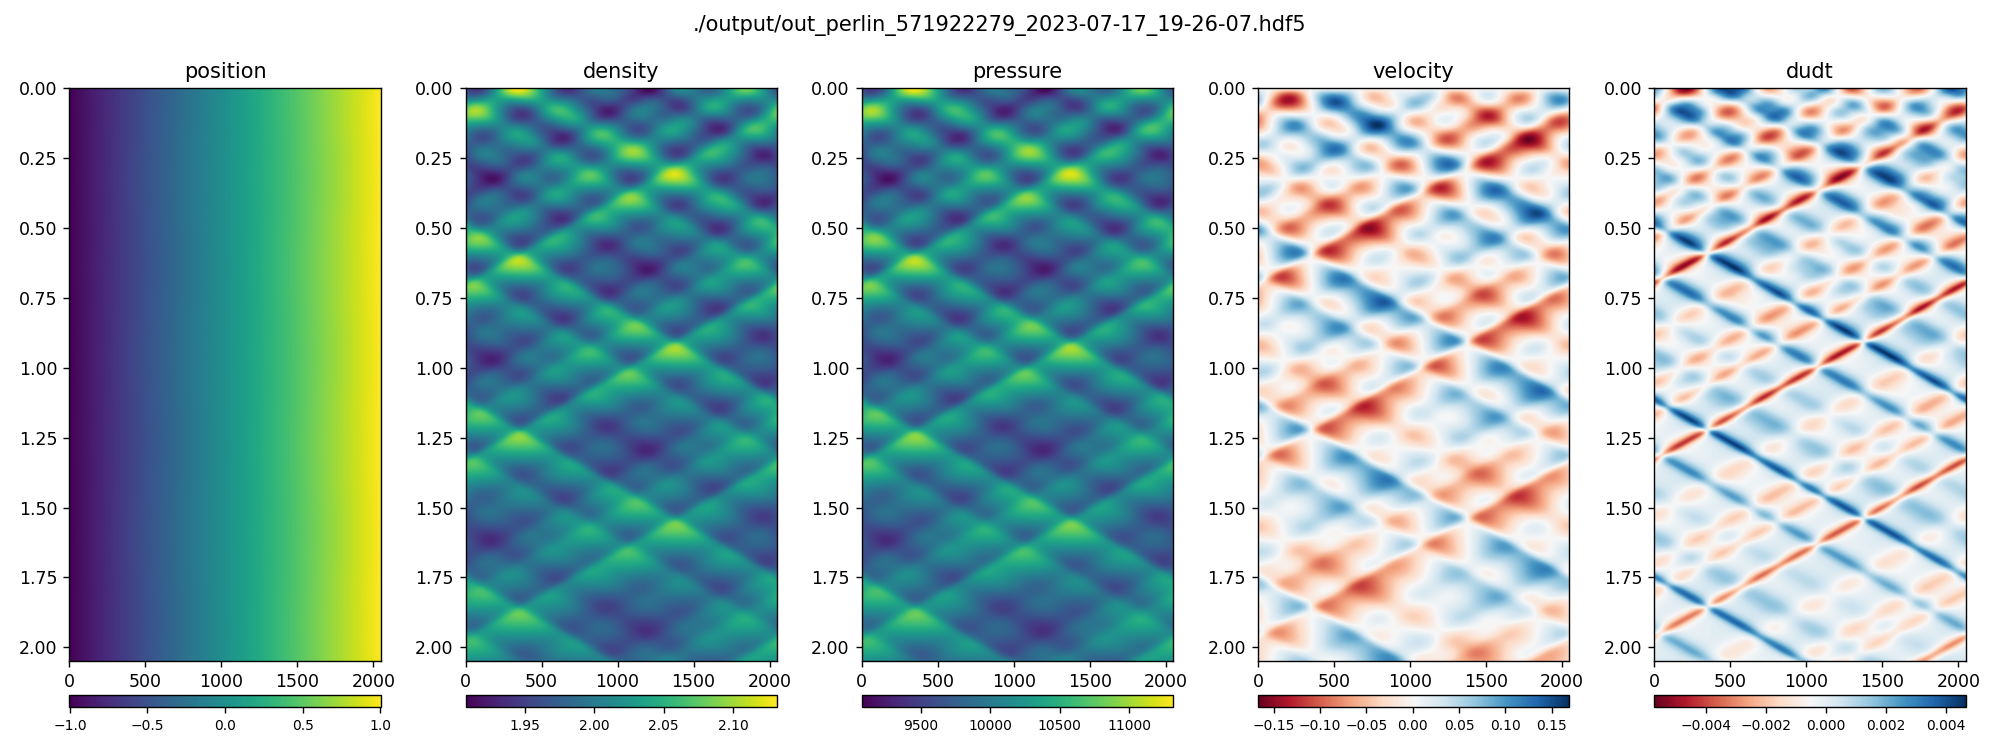

In [5]:
def loadFile(t, plot = False):
    inFile = h5py.File(t,'r')
    fluidPositions = np.array(inFile['simulationData']['fluidPosition'])
    
    fluidVelocities = np.array(inFile['simulationData']['fluidVelocities'])
    fluidDensity = np.array(inFile['simulationData']['fluidDensity'])
    fluidPressure = np.array(inFile['simulationData']['fluidPressure'])
    fluidAreas = np.array(inFile['simulationData']['fluidAreas'])
    dudt = np.array(inFile['simulationData']['dudt'])
    if plot:
        fig, axis = plt.subplots(1, 5, figsize=(16,6), sharex = False, sharey = False, squeeze = False)

        def plot(fig, axis, mat, title, cmap = 'viridis'):
            im = axis.imshow(mat, extent = [0,numParticles,dt * timesteps,0], cmap = cmap)
            axis.axis('auto')
            ax1_divider = make_axes_locatable(axis)
            cax1 = ax1_divider.append_axes("bottom", size="2%", pad="6%")
            cb1 = fig.colorbar(im, cax=cax1,orientation='horizontal')
            cb1.ax.tick_params(labelsize=8) 
            axis.set_title(title)
        plot(fig,axis[0,0], fluidPositions, 'position')
        plot(fig,axis[0,1], fluidDensity, 'density')
        plot(fig,axis[0,2], fluidPressure, 'pressure')
        plot(fig,axis[0,3], fluidVelocities, 'velocity', 'RdBu')
        plot(fig,axis[0,4], dudt, 'dudt', 'RdBu')

        fig.suptitle(t)
        fig.tight_layout()
    inFile.close()
    return {'positions': torch.tensor(fluidPositions).type(torch.float32), 'density': torch.tensor(fluidDensity).type(torch.float32), 'pressure':torch.tensor(fluidPressure).type(torch.float32), 'area': torch.tensor(fluidAreas).type(torch.float32), 'velocity': torch.tensor(fluidVelocities).type(torch.float32), 'dudt' : torch.tensor(dudt).type(torch.float32)}
data = loadFile(trainingFiles[0], True)

In [6]:
# ns = int(np.sqrt(len(trainingFiles)))
# fig, axis = plt.subplots(ns, ns, figsize=(ns*6,ns * 2), sharex = True, sharey = True, squeeze = False)

# def plot(fig, axis, mat, title, cmap = 'viridis'):
#     im = axis.imshow(mat, extent = [0,dt * timesteps,numParticles,0], cmap = cmap)
#     axis.axis('auto')
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="2%", pad="6%")
#     cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
#     cb1.ax.tick_params(labelsize=8) 
#     axis.set_title(title)

# for i in range(ns):
#     for j in range(ns):
#         data = loadFile(trainingFiles[ns * j + i], False)
#         plot(fig,axis[i,j], data['velocity'].mT, trainingFiles[ns * j + i].split('/')[-1].split('.')[0].split('_')[2], 'RdBu')
# #         plot(fig,axis[i,j], data['dudt'].mT, trainingFiles[ns * j + i].split('/')[-1].split('.')[0].split('_')[2], 'RdBu')

# fig.tight_layout()

In [7]:

# fig, axis = plt.subplots(1, len(testingFiles), figsize=(len(testingFiles)*3,6), sharex = False, sharey = False, squeeze = False)

# def plot(fig, axis, mat, title, cmap = 'viridis'):
#     im = axis.imshow(mat, extent = [0,numParticles,dt * timesteps,0], cmap = cmap)
#     axis.axis('auto')
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("bottom", size="2%", pad="6%")
#     cb1 = fig.colorbar(im, cax=cax1,orientation='horizontal')
#     cb1.ax.tick_params(labelsize=8) 
#     axis.set_title(title)
    
# for i in range(len(testingFiles)):
#     data = loadFile(testingFiles[i], False)
#     plot(fig,axis[0,i], data['velocity'], testingFiles[i].split('/')[-1].split('.')[0], 'RdBu')

# fig.suptitle('Test Samples')
# fig.tight_layout()

In [8]:
trainingData = {}
for f in tqdm(trainingFiles):
    trainingData[f] = loadFile(f, False)
testingData = {}
for f in tqdm(testingFiles):
    testingData[f] = loadFile(f, False)

# inFile.close()

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
print(dt)

0.001


In [10]:
# offset = 1

# positions = particleData[trainingFiles[0]]['positions']
# velocities = particleData[trainingFiles[0]]['velocity']
# accelerations = particleData[trainingFiles[0]]['dudt']
# dx = dt * velocities + dt **2 * accelerations

# x = dx.mT
# cumsum = torch.cumsum(x, axis = 1)
# s = torch.sum(x, axis = 1, keepdims=True)
# r2lcumsum = x + s - cumsum
# stacked = torch.hstack((r2lcumsum[:,:-offset] - r2lcumsum[:,offset:], r2lcumsum[:,-offset:]))

# fig, axis = plt.subplots(3, 1, figsize=(16,9), sharex = True, sharey = False, squeeze = False)
# axis[0,0].imshow(dx.mT.detach().cpu().numpy(), cmap = 'RdBu')
# axis[0,0].axis('auto')

# axis[1,0].imshow(r2lcumsum.detach().cpu().numpy(), cmap = 'RdBu')
# axis[1,0].axis('auto')

# axis[2,0].imshow(stacked.detach().cpu().numpy(), cmap = 'RdBu')
# axis[2,0].axis('auto')

# fig.tight_layout()

# Task: Learn density (1 timestep)

In [11]:
normalized = False # rbf normalization
batchSize = 4
maxUnrollsteps = 16
offset = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
dataSet = []
for f in trainingFiles:
    nSteps = settings[f]['timesteps'] - maxUnrollsteps
    for j in range(offset, nSteps):
        dataSet.append((f, j))
print('Dataset contains %d samples [%d files @ %d timesteps]' % (len(dataSet), len(trainingFiles), nSteps))

Dataset contains 72576 samples [36 files @ 2032 timesteps]


In [12]:
torch.manual_seed('1337')

dataLoader = DataLoader(dataSet, shuffle=True, batch_size = batchSize).batch_sampler
dataIter = iter(dataLoader)

In [13]:
from util import *

In [14]:
def getGroundTruth(positions, velocities, areas, densities, dudts):
#     print(dudts, dt)
#     gt = [v + d for v,d in zip(velocities, dudts)] # Learning Density
#     gt = dudts
    gt = velocities
#     gt = densities
    groundTruth = torch.hstack(gt)
    return groundTruth
def getFeatures(positions, velocities, areas, densities, dudts):
    features = torch.vstack((velocities, torch.ones_like(areas))).mT
    return features
#     features = torch.ones_like(areas)
#     return features[:,None]
def lossFunction(prediction, groundTruth):
    return (prediction - groundTruth)**2 # MSE

In [15]:
# Hyperparameters for the NN
lr = 1e-2 # Learning rate
iterations = 1000 # update iterations per epoch
epochs = 5 # total number of epochs, LR is halved every epoch
n = 17 # number of weights per continuous convolution
basis = 'fourier' # basis for the convolution, set to linear for CConv

window = 'cubicSpline'
windowNorm = 'integral'
window = None

In [16]:
layers = [1]
initialLR = 1e-2
particleData = trainingData
groundTruthFn = getGroundTruth
featureFn = getFeatures
lossFn = lossFunction

In [17]:
print(particleSupport)
print(dt)

0.0078125
0.001


In [18]:
testData = {}
for i in range(len(testingFiles)):
    testData[testingFiles[i].split('/')[-1].split('.')[0]] = loadTestcase(testingData, settings, testingFiles[i], [0, 128, 256, 1024], device, getGroundTruth, getFeatures)
# testData = {}
# for i in range(len(testingFiles)):
#     testData[testingFiles[i].split('/')[-1].split('.')[0]] = loadTestcase(testingData, settings, testingFiles[i], [0], device, getGroundTruth, getFeatures)

In [19]:
# print(features.shape[1])

In [20]:
positions, velocities, areas, dudts, density, setup = loadBatch(trainingData, settings, dataSet, [0], device)
i, j, distance, direction = batchedNeighborsearch(positions, setup)
x, u, v, rho, dudt = flatten(positions, velocities, areas, density, dudts)
x = x[:,None].to(device)    
groundTruth = groundTruthFn(positions, velocities, areas, density, dudts).to(device)
distance = (distance * direction)[:,None].to(device)
features = featureFn(x, u, v, rho, dudt).to(device)

def convert_bytes(size):
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return "%3.1f %s" % (size, x)
        size /= 1024.0

    return size

entries = (1 + features.shape[1] + 1) * positions[0].shape[0]
featureCount = features.shape[1]
print(entries)
print(len(dataSet))
print('Matrix requires ', convert_bytes(entries * len(dataSet) * 4 ))
dataMatrix = torch.zeros((len(dataSet), entries), dtype = torch.float32)

cumRows = 0
for f in tqdm(trainingFiles):    
    nSteps = settings[f]['timesteps'] - maxUnrollsteps
    dataMatrix[cumRows:cumRows + nSteps - offset,0:2048] = trainingData[f]['positions'][offset:nSteps,:]
    data = [featureFn(x,u,v,rho,dudt) for x,u,v,rho,dudt in zip(trainingData[f]['positions'][offset:nSteps,:], trainingData[f]['velocity'][offset:nSteps,:], trainingData[f]['area'][offset:nSteps,:], trainingData[f]['density'][offset:nSteps,:], trainingData[f]['dudt'][offset:nSteps,:])]
#     print(torch.stack(data, dim = 0).flatten(-2).shape)
    dataMatrix[cumRows:cumRows + nSteps - offset,2048 * 1:2048 * 3] = torch.stack(data, dim = 0).flatten(-2)
    gtdata = [getGroundTruth([x],[u],[v],[rho],[dudt]) for x,u,v,rho,dudt in zip(trainingData[f]['positions'][offset:nSteps,:], trainingData[f]['velocity'][offset:nSteps,:], trainingData[f]['area'][offset:nSteps,:], trainingData[f]['density'][offset:nSteps,:], trainingData[f]['dudt'][offset:nSteps,:])]
    dataMatrix[cumRows:cumRows + nSteps - offset,2048 * 3:2048 * 4] = torch.stack(gtdata, dim = 0)
    
    cumRows += nSteps - offset
dataMatrix = dataMatrix.to(device)

8192
72576
Matrix requires  2.2 GB


  0%|          | 0/36 [00:00<?, ?it/s]

In [21]:
steps = np.sum([len(testData[k][0]) for k in testData.keys()])
for k in testData.keys():
    print(len(testData[k][0]))
    break
print(steps)

4
16


In [22]:
# def convert_bytes(size):
#     for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
#         if size < 1024.0:
#             return "%3.1f %s" % (size, x)
#         size /= 1024.0

#     return size

# entries = (1 + features.shape[1] + 1) * positions[0].shape[0]
# print(entries)
# print(steps)
# print('Matrix requires ', convert_bytes(entries * steps * 4 ))
# testMatrix = torch.zeros((steps, entries), dtype = torch.float32)

# testData[testingFiles[i].split('/')[-1].split('.')[0]] = loadTestcase(testingData, settings, testingFiles[i], [0, 128, 256, 1024], device, getGroundTruth, getFeatures)
    
# cumRows = 0
# for k in testData.keys():
#     for t in range(len(testData[k][0])):
#         testMatrix[cumRows:cumRows+1, 0: 2048] = testData[k][t]
        
#         cumRows += 1

# for f in tqdm(trainingFiles):    
#     nSteps = settings[f]['timesteps'] - maxUnrollsteps
#     dataMatrix[cumRows:cumRows + nSteps - offset,0:2048] = trainingData[f]['positions'][offset:nSteps,:]
#     data = [featureFn(x,u,v,rho,dudt) for x,u,v,rho,dudt in zip(trainingData[f]['positions'][offset:nSteps,:], trainingData[f]['velocity'][offset:nSteps,:], trainingData[f]['area'][offset:nSteps,:], trainingData[f]['density'][offset:nSteps,:], trainingData[f]['dudt'][offset:nSteps,:])]
# #     print(torch.stack(data, dim = 0).flatten(-2).shape)
#     dataMatrix[cumRows:cumRows + nSteps - offset,2048 * 1:2048 * 3] = torch.stack(data, dim = 0).flatten(-2)
#     gtdata = [getGroundTruth([x],[u],[v],[rho],[dudt]) for x,u,v,rho,dudt in zip(trainingData[f]['positions'][offset:nSteps,:], trainingData[f]['velocity'][offset:nSteps,:], trainingData[f]['area'][offset:nSteps,:], trainingData[f]['density'][offset:nSteps,:], trainingData[f]['dudt'][offset:nSteps,:])]
#     dataMatrix[cumRows:cumRows + nSteps - offset,2048 * 3:2048 * 4] = torch.stack(gtdata, dim = 0)
    
#     cumRows += nSteps - offset
# testMatrix = testMatrix.to(device)

In [23]:
try:
    bdata = next(dataIter)
    if len(bdata) < batchSize :
        raise Exception('batch too short')
except:
    dataIter = iter(dataLoader)
    bdata = next(dataIter)
    
print(bdata)

[39059, 17506, 27290, 54940]


In [24]:
dataRows = dataMatrix[bdata,:]
i, j, distance, direction = batchedNeighborsearch([dataRows[i,:2048] for i in range(dataRows.shape[0])], setup)
x = dataRows[:,:2048].flatten()[:,None]
features = dataRows[:,2048*1: 2048 * (1 + featureCount)].flatten(0).reshape(x.shape[0], featureCount)
gt = dataRows[:,2048*(1+featureCount):].flatten()

print('x', x.shape)
print(gt)
print(gt.shape)
print(features)
print(features.shape)

# positions = [dataMatrix[]]

x torch.Size([8192, 1])
tensor([ 0.0352,  0.0348,  0.0345,  ..., -0.0662, -0.0663, -0.0665],
       device='cuda:0')
torch.Size([8192])
tensor([[ 0.0352,  1.0000],
        [ 0.0348,  1.0000],
        [ 0.0345,  1.0000],
        ...,
        [-0.0662,  1.0000],
        [-0.0663,  1.0000],
        [-0.0665,  1.0000]], device='cuda:0')
torch.Size([8192, 2])


In [25]:

positions, velocities, areas, dudts, density, setup = loadBatch(trainingData, settings, dataSet, bdata, device)
i, j, distance, direction = batchedNeighborsearch(positions, setup)
print(i.shape)
print(i)

torch.Size([131077])
tensor([   0,    0,    0,  ..., 8191, 8191, 8191], device='cuda:0')


In [50]:
def trainModel(particleData, dataMatrix, testData, settings, dataSet, trainingFiles, fluidFeatures = 1, n = 16, basis = 'linear', layers = [1], window = None, windowNorm = None, epochs = 5, iterations = 1000, testInterval = 10, initialLR = 1e-2, groundTruthFn = None, featureFn = None, lossFn = None, device = 'cpu'):   
    windowFn = getWindowFunction(window, norm = windowNorm) if window is not None else None
    model = RbfNet(fluidFeatures = fluidFeatures, 
                   layers = layers, 
                   denseLayer = True, activation = 'ReLU', coordinateMapping = 'cartesian', 
                   n = n, windowFn = windowFn, rbf = basis, batchSize = 32, ignoreCenter = True, normalized = False).to(device)   
    lr = initialLR
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)
    losses = []
    lossValues = []
    testLosses = {}
    testPredictions = {}
    for e in (pb := tqdm(range(epochs), leave = False)):
        epochLosses = []
        epochLossValues = []
        for b in (pbl := tqdm(range(iterations), leave=False)):
            
            try:
                bdata = next(dataIter)
                if len(bdata) < batchSize :
                    raise Exception('batch too short')
            except:
                dataIter = iter(dataLoader)
                bdata = next(dataIter)
            dataRows = dataMatrix[bdata,:]
            i, j, distance, direction = batchedNeighborsearch([dataRows[i,:2048] for i in range(dataRows.shape[0])], setup)
            distance = (distance * direction)[:,None].to(device)
            x = dataRows[:,:2048].flatten()[:,None]
            features = dataRows[:,2048*1: 2048 * (1 + featureCount)].flatten(0).reshape(x.shape[0], featureCount)
            groundTruth = dataRows[:,2048*(1+featureCount):].flatten()
            
#             print(x.shape)
#             print(features.shape)
#             print(groundTruth.shape)
#             positions, velocities, areas, dudts, density, setup = loadBatch(trainingData, settings, dataSet, bdata, device)
#             i, j, distance, direction = batchedNeighborsearch(positions, setup)
#             x, u, v, rho, dudt = flatten(positions, velocities, areas, density, dudts)

#             x = x[:,None].to(device)    
#             groundTruth = groundTruthFn(positions, velocities, areas, density, dudts).to(device)
#             distance = (distance * direction)[:,None].to(device)
#             features = featureFn(x, u, v, rho, dudt).to(device)

            optimizer.zero_grad()
            prediction = model(features, i, j, distance)[:,0]
#             prediction = model(features.to(device), i.to(device), j.to(device), distance.to(device))[:,0]
#             print(prediction.shape)
            lossTerm = lossFn(prediction, groundTruth)
            loss = torch.mean(lossTerm)

            loss.backward()
            optimizer.step()
            epochLosses.append(torch.sort(lossTerm.detach())[0])
            epochLossValues.append(loss.detach())
            
#             losses.append(lossTerm.detach().cpu())
#             lossValues.append(loss.detach().cpu().item())

            lossString = np.array2string(torch.mean(lossTerm.reshape(batchSize, positions[0].shape[0]),dim=1).detach().cpu().numpy(), formatter={'float_kind':lambda x: "%.4e" % x})
            batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%6d' % x}))

            pbl.set_description('%s:  %s -> %.4e' %(batchString, lossString, loss.detach().cpu().numpy()))
            pb.set_description('epoch %2dd, lr %6.4g: loss %.4e [rolling %.4e]' % (e, lr, torch.mean(torch.hstack(epochLossValues)), torch.mean(torch.hstack(epochLossValues[-100:]) if len(epochLossValues) > 100 else torch.hstack(epochLossValues))))
            
            it = e * iterations + b
            if it % testInterval == 0:
                with torch.no_grad():
                    testLossDict = {}
                    testPreds = {}
                    for i, k in  enumerate(testData.keys()):
                        gt = testData[k][9].reshape(len(testData[k][0]), testData[k][0][0].shape[0])
                        prediction = model(testData[k][5], testData[k][6], testData[k][7], testData[k][8]).reshape(len(testData[k][0]), testData[k][0][0].shape[0])
                        arr = []
                        for i, (xs, pred, gt) in enumerate(zip(testData[k][0], prediction, gt)):
                             arr.append(lossFn(pred, gt).detach().cpu().numpy())
                        testLossDict[k] = arr
                        testPreds[k] = prediction.detach().cpu()
#                         print(testLossDict[k])
                    testLosses[it] = testLossDict
                    testPredictions[it] = testPreds
#             break

        hEpochLosses=  torch.stack(epochLosses, dim = 0).cpu()
        hEpochLossValues = torch.stack(epochLossValues,dim = 0).cpu()
        [losses.append(hEpochLosses[l]) for l in range(hEpochLosses.shape[0])]
        [lossValues.append(hEpochLossValues[l].item()) for l in range(hEpochLossValues.shape[0])]
#         break
    return {'model': model, 'optimizer': optimizer, 'finalLR': lr, 'losses': losses, 'testLosses': testLosses, 'testPredictions': testPredictions,
            'window': window, 'windowNorm': windowNorm, 'n':n, 'basis':basis, 'layers':layers, 'epochs': epochs, 'iterations': iterations, 'fluidFeatures': fluidFeatures          
           }

In [51]:
n = 5

In [57]:
basis = 'fourier'

In [58]:
trainedModel = trainModel(particleData, dataMatrix, testData, settings, dataSet, trainingFiles, fluidFeatures = 2,
                          n = n, basis = basis, layers = [8,16,16,1],
                         window = window, windowNorm = windowNorm,
                         epochs = 10, iterations = 100, initialLR = 1e-3, device = device, testInterval = 1000,
                         groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [59]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    trainedModel = trainModel(particleData, dataMatrix, testData, settings, dataSet, trainingFiles, fluidFeatures = 2,
                          n = n, basis = basis, layers = [4,4,1],
                         window = window, windowNorm = windowNorm,
                         epochs = 10, iterations = 10, initialLR = 1e-3, device = device, testInterval = 100,
                         groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)
    

# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
autograd::engine::evaluate_function: cutlassBackward...         0.10%       5.914ms        38.68%        2.216s       7.385ms           0 b           0 b    -275.15 Mb    -350.34 Mb           300  
                                        cutlassBackward         0.28%      16.029ms        38.46%        2.203s       7.344ms           0 b           0 b      37.70 Mb      -2.88 Gb           300  
         

<IPython.core.display.Javascript object>


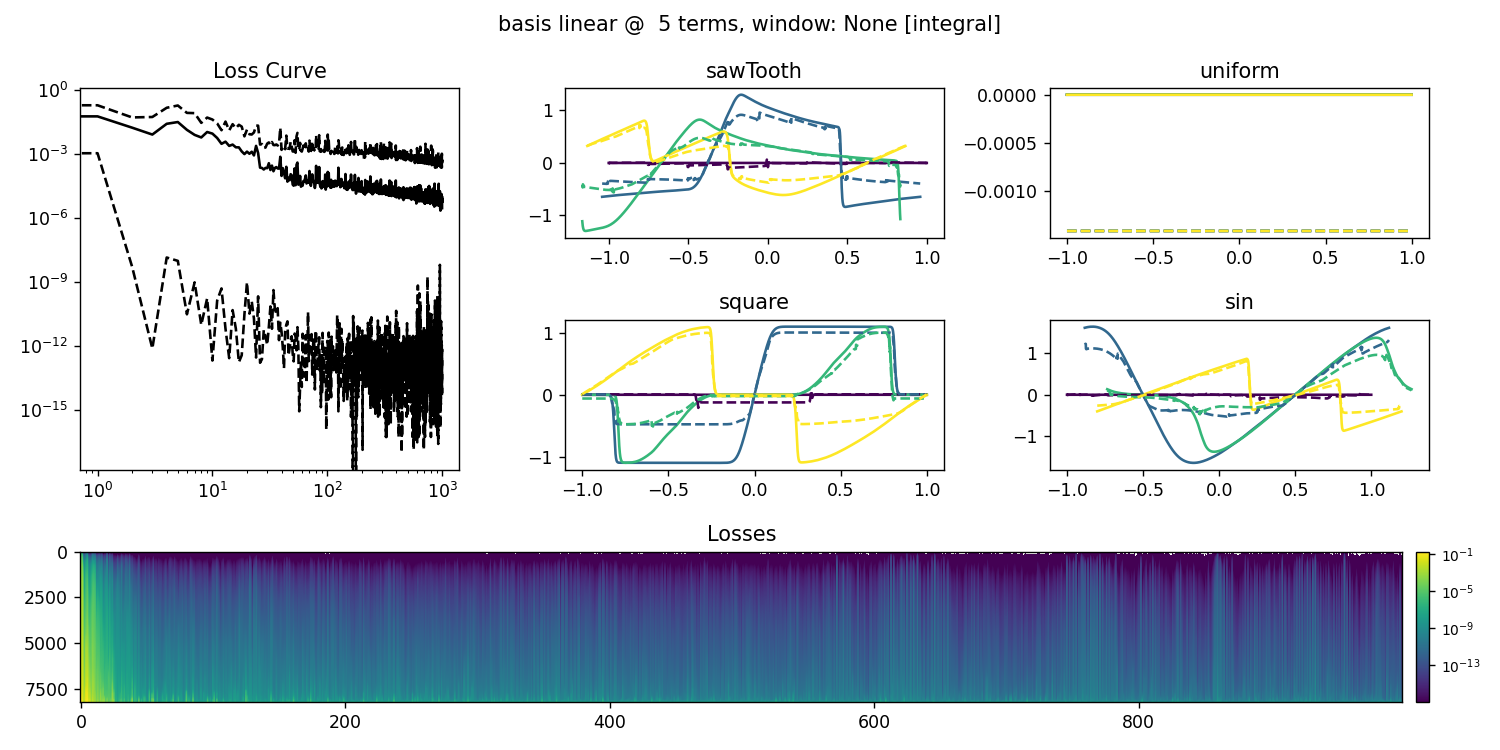

In [56]:
plotModel(trainedModel, testData, device, baseArea, particleSupport)

<IPython.core.display.Javascript object>


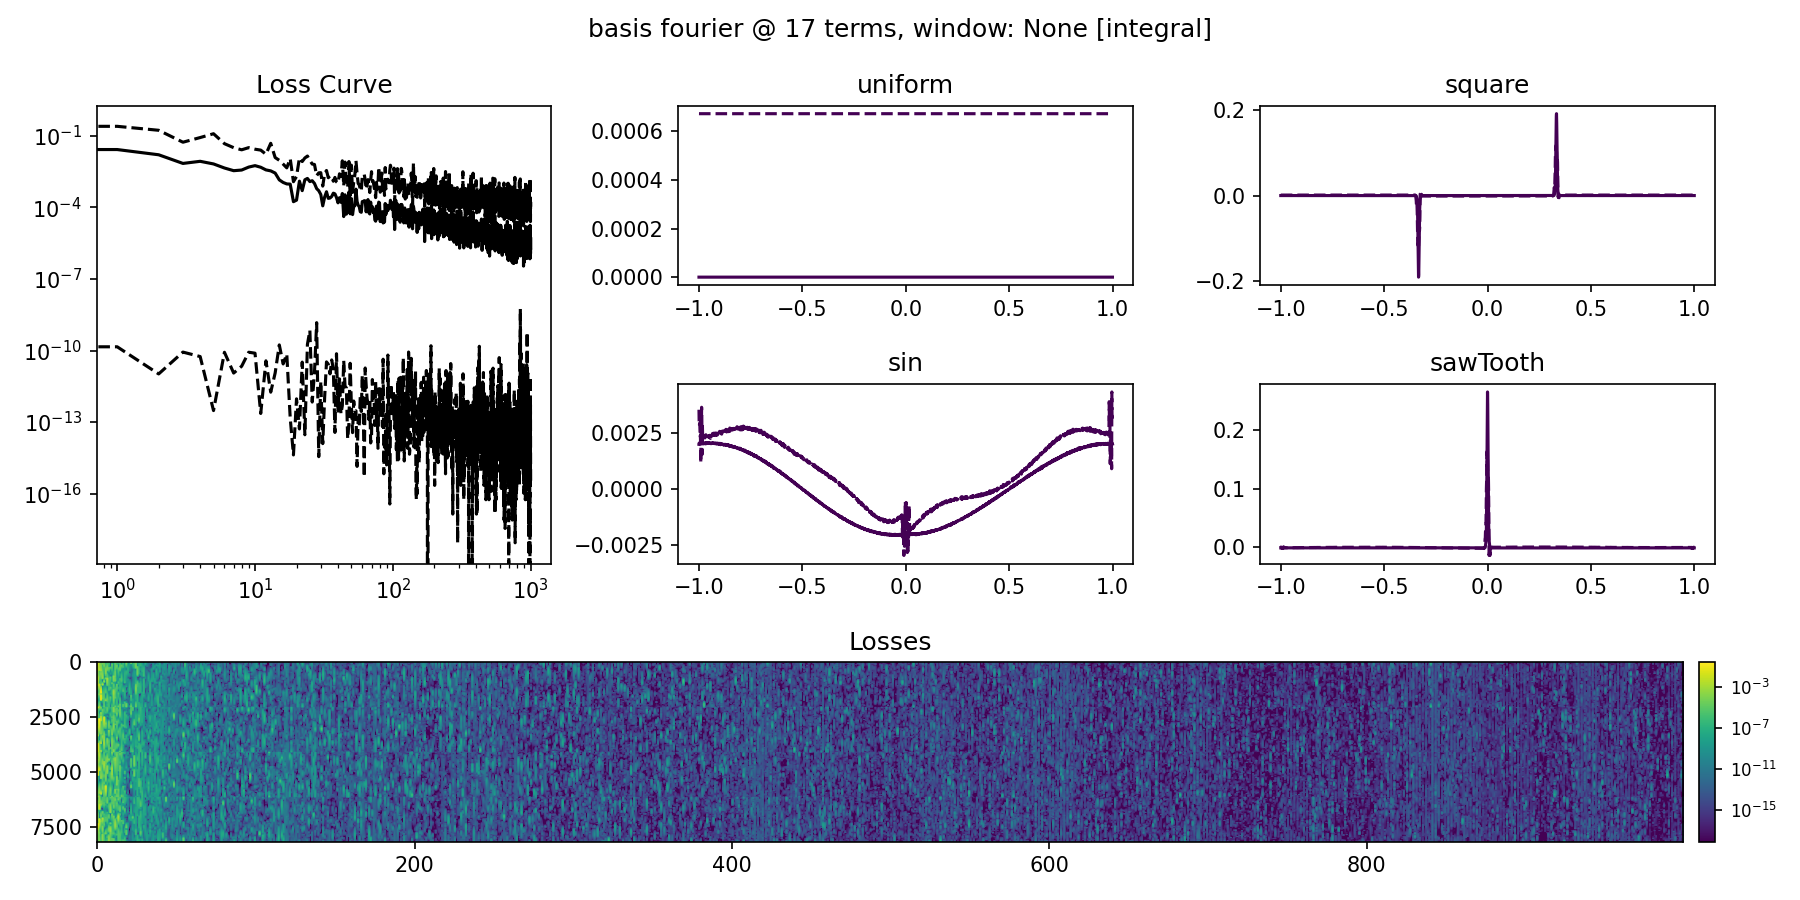

In [188]:
plotModel(trainedModel, testData, device, baseArea, particleSupport)

<IPython.core.display.Javascript object>


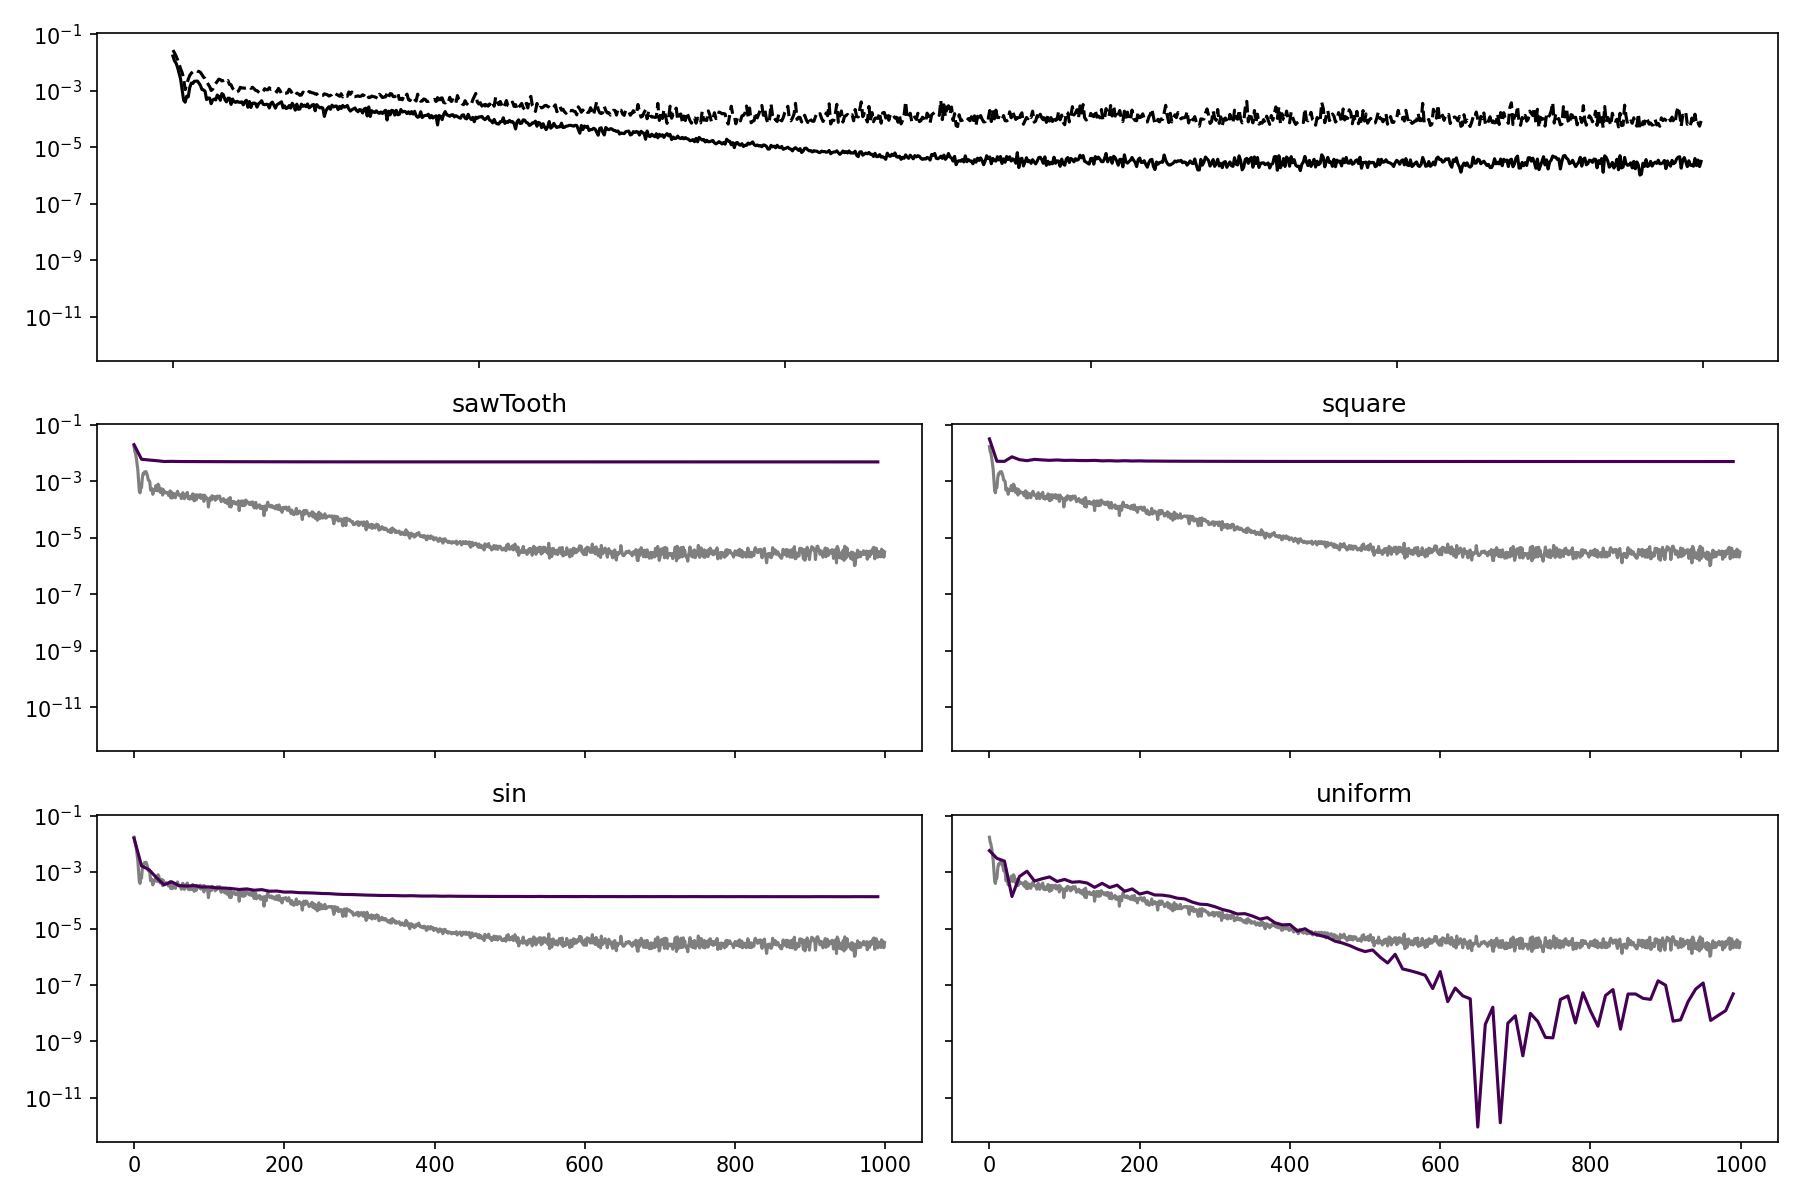

In [26]:
plotLosses(trainedModel, testData)

In [57]:
models = []
nMax = 32
for i in tqdm(range(1,nMax + 1)):
    trainedModel = trainModel(particleData, testData, settings, dataSet, trainingFiles,
                          n = i, basis = basis, layers = layers,
                         window = window, windowNorm = windowNorm,
                         epochs = epochs, iterations = 1000, initialLR = 1e-2, device = device, testInterval = 10,
                         groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)
    models.append(trainedModel)
#     break

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


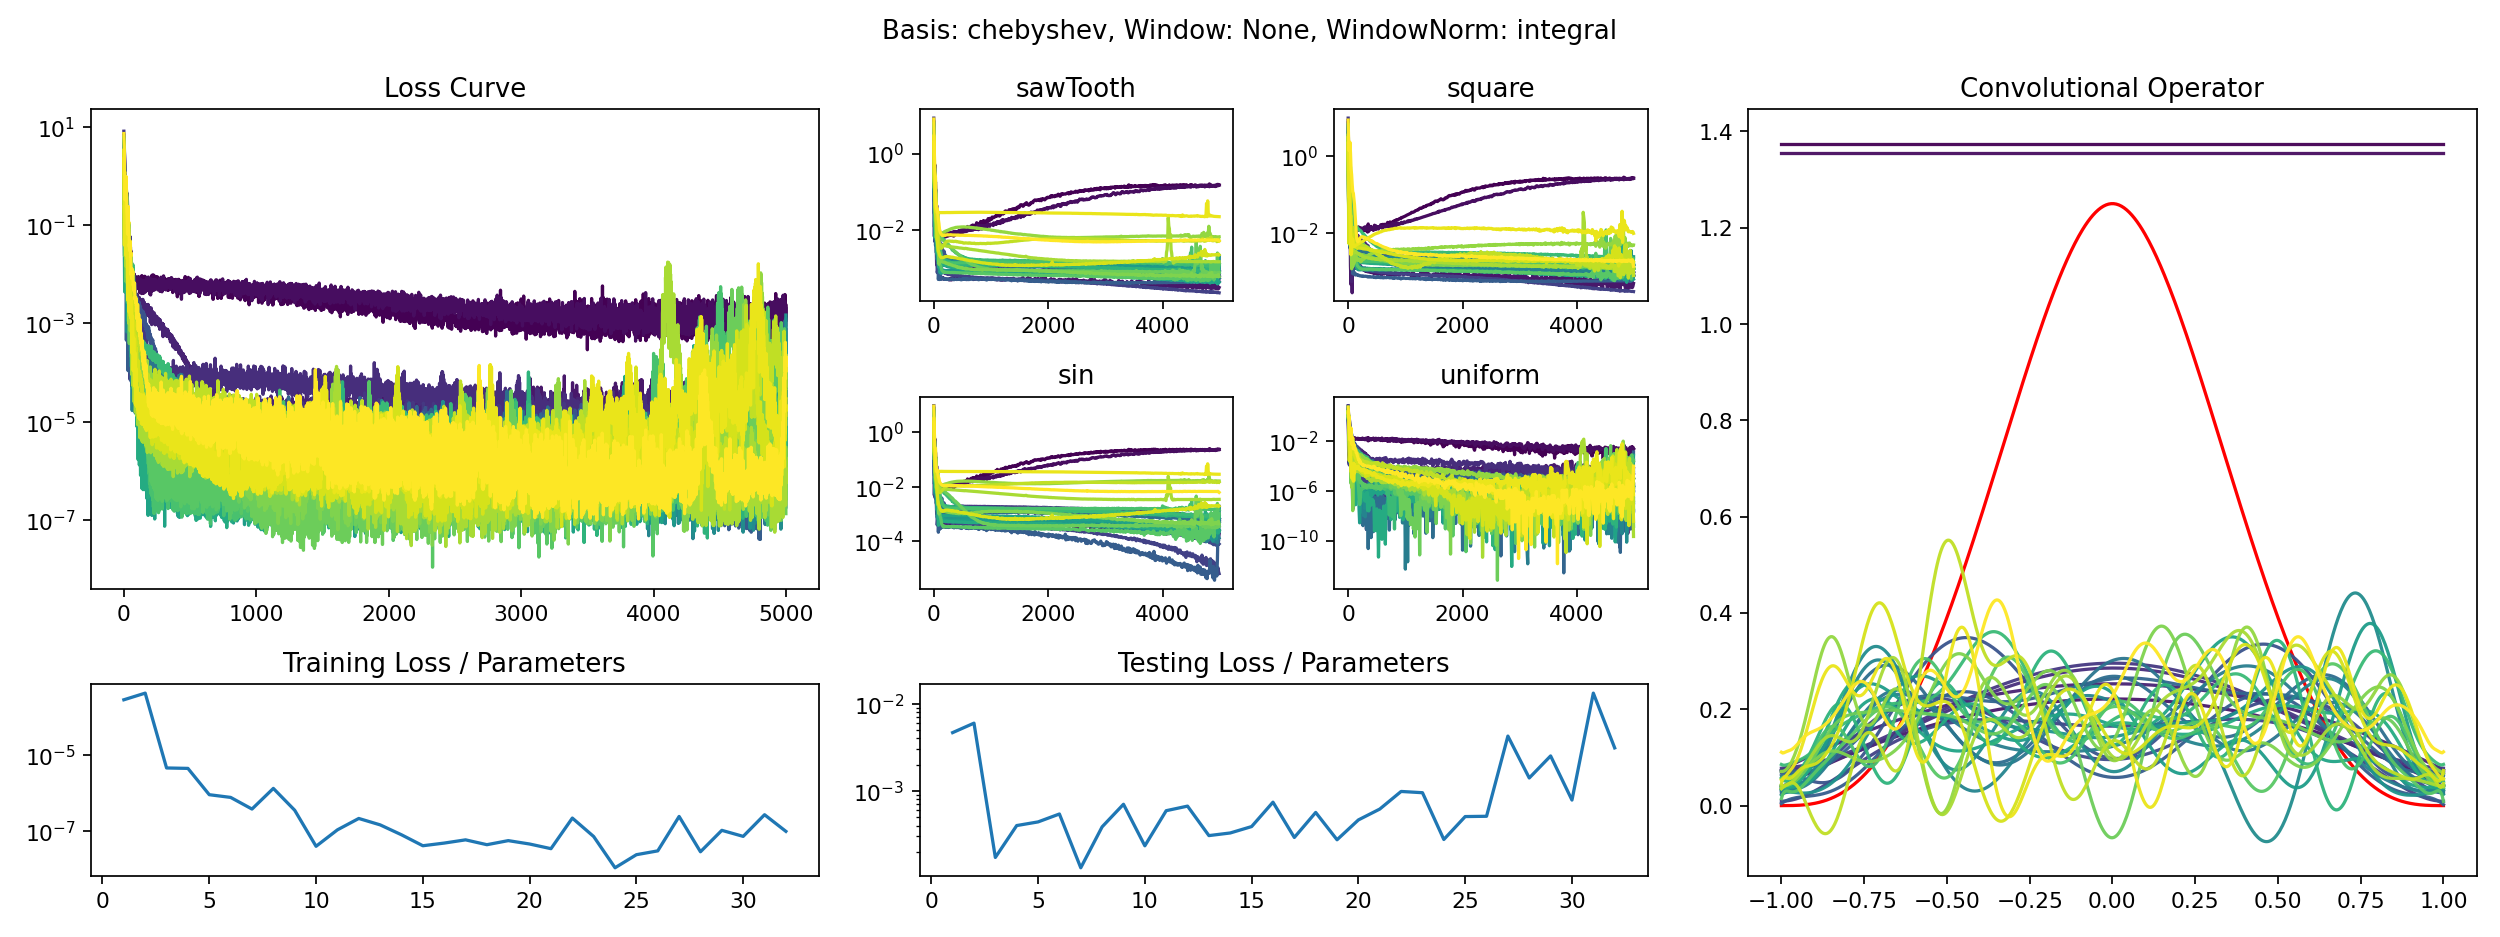

In [51]:
plotModelset2(models, testData, device,nMax)

<IPython.core.display.Javascript object>


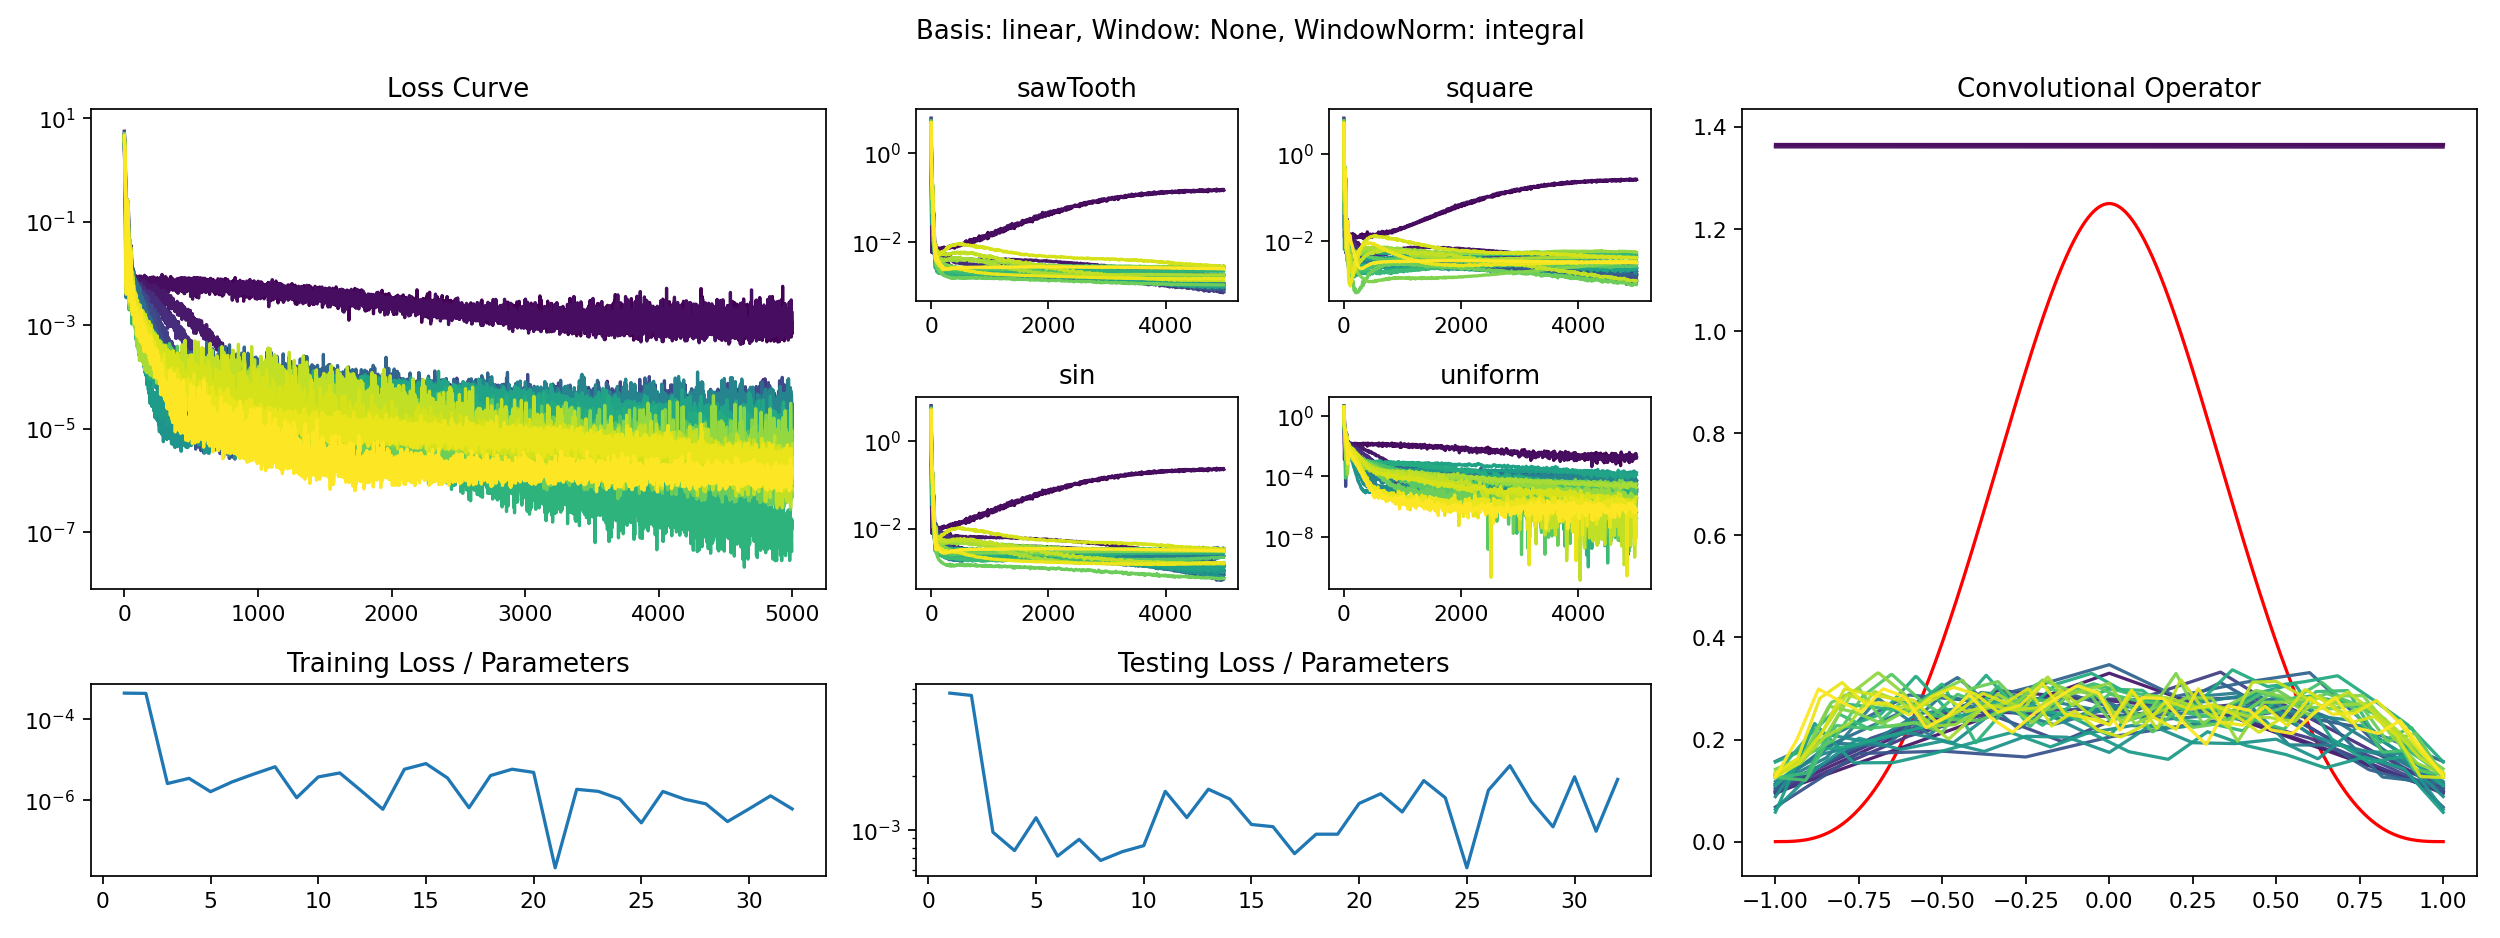

In [58]:
plotModelset2(models, testData, device,nMax)

<IPython.core.display.Javascript object>


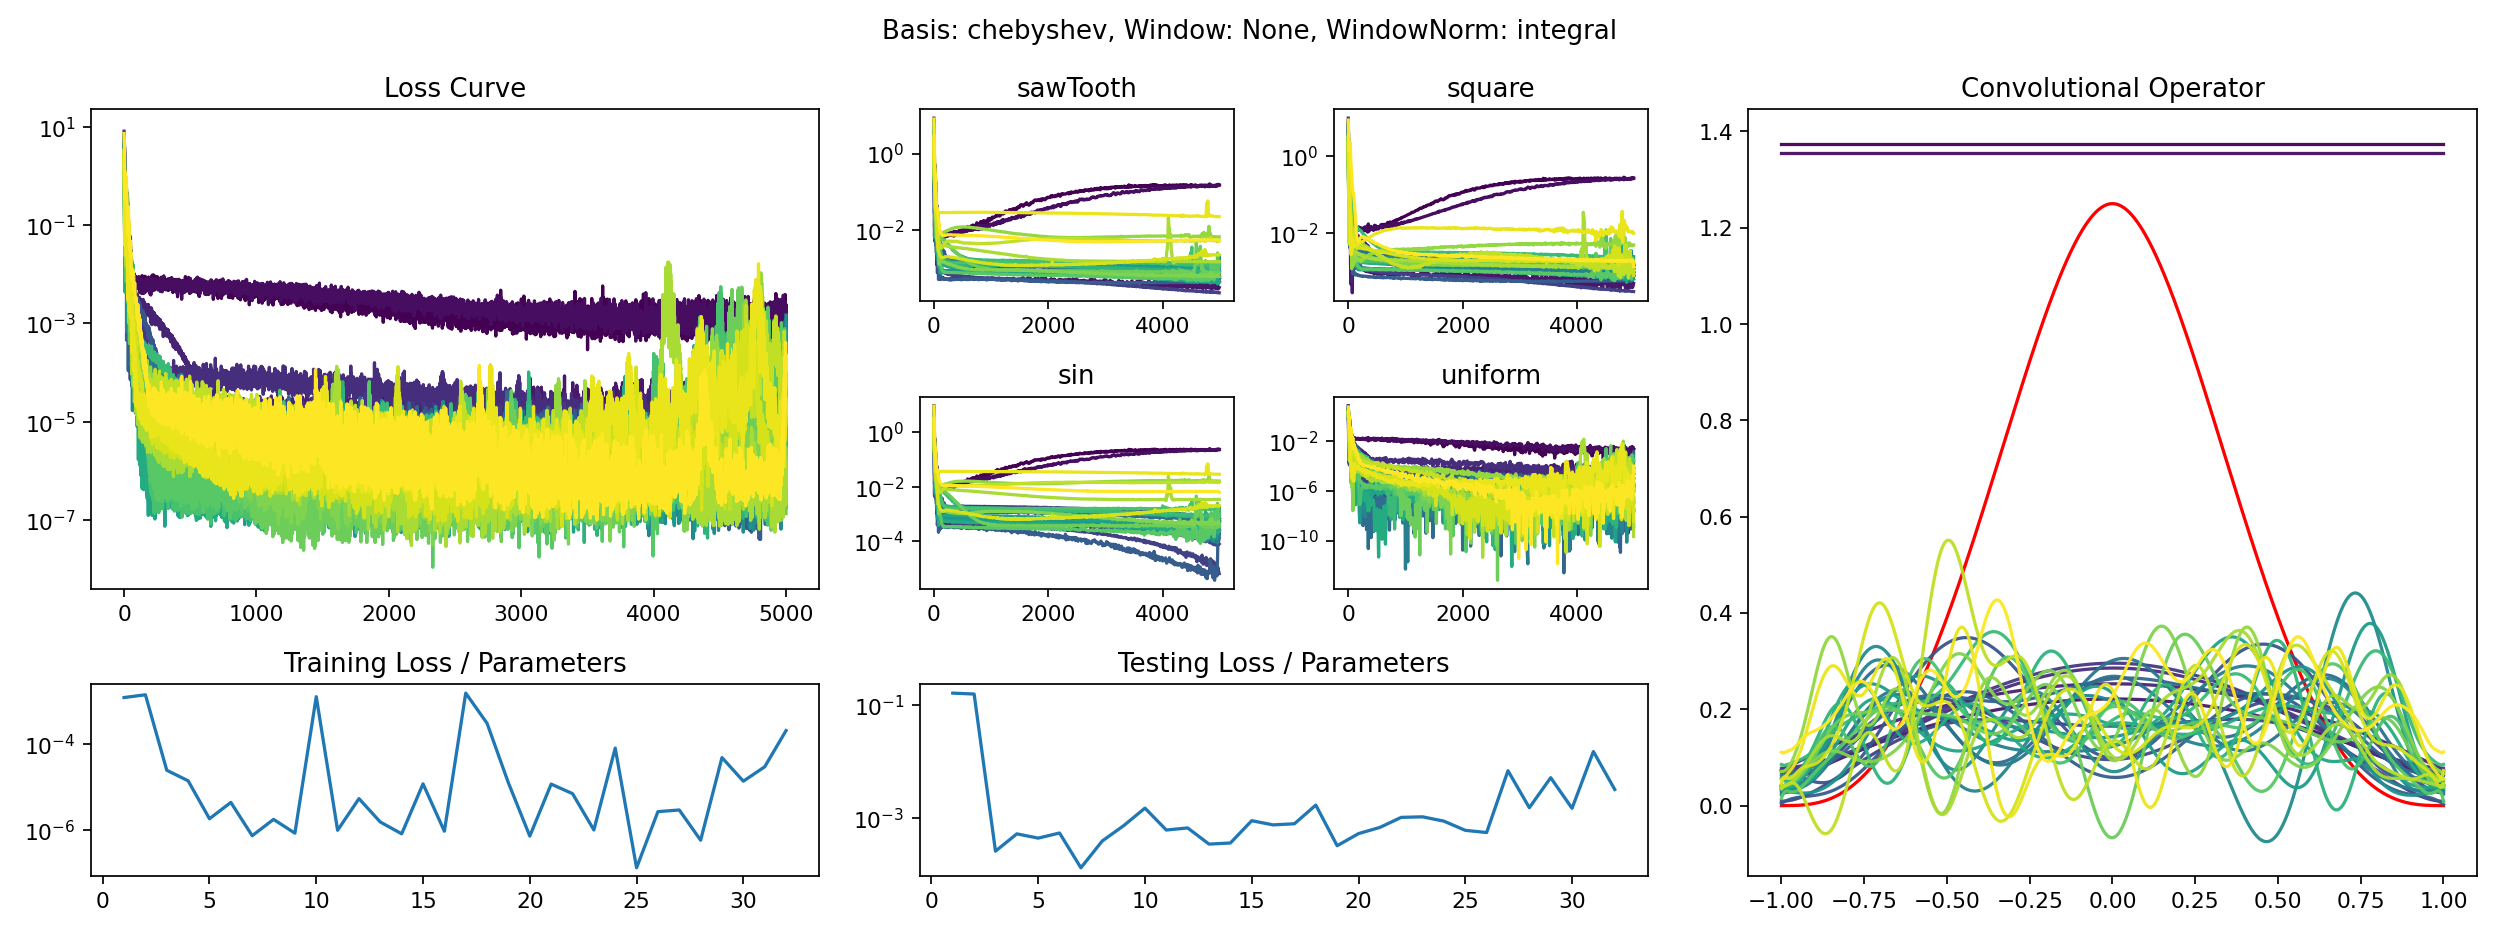

In [47]:
plotModelset2(models, testData, device,nMax)

In [26]:
plotModelset(models, device)

NameError: name 'plotModelset' is not defined

<IPython.core.display.Javascript object>


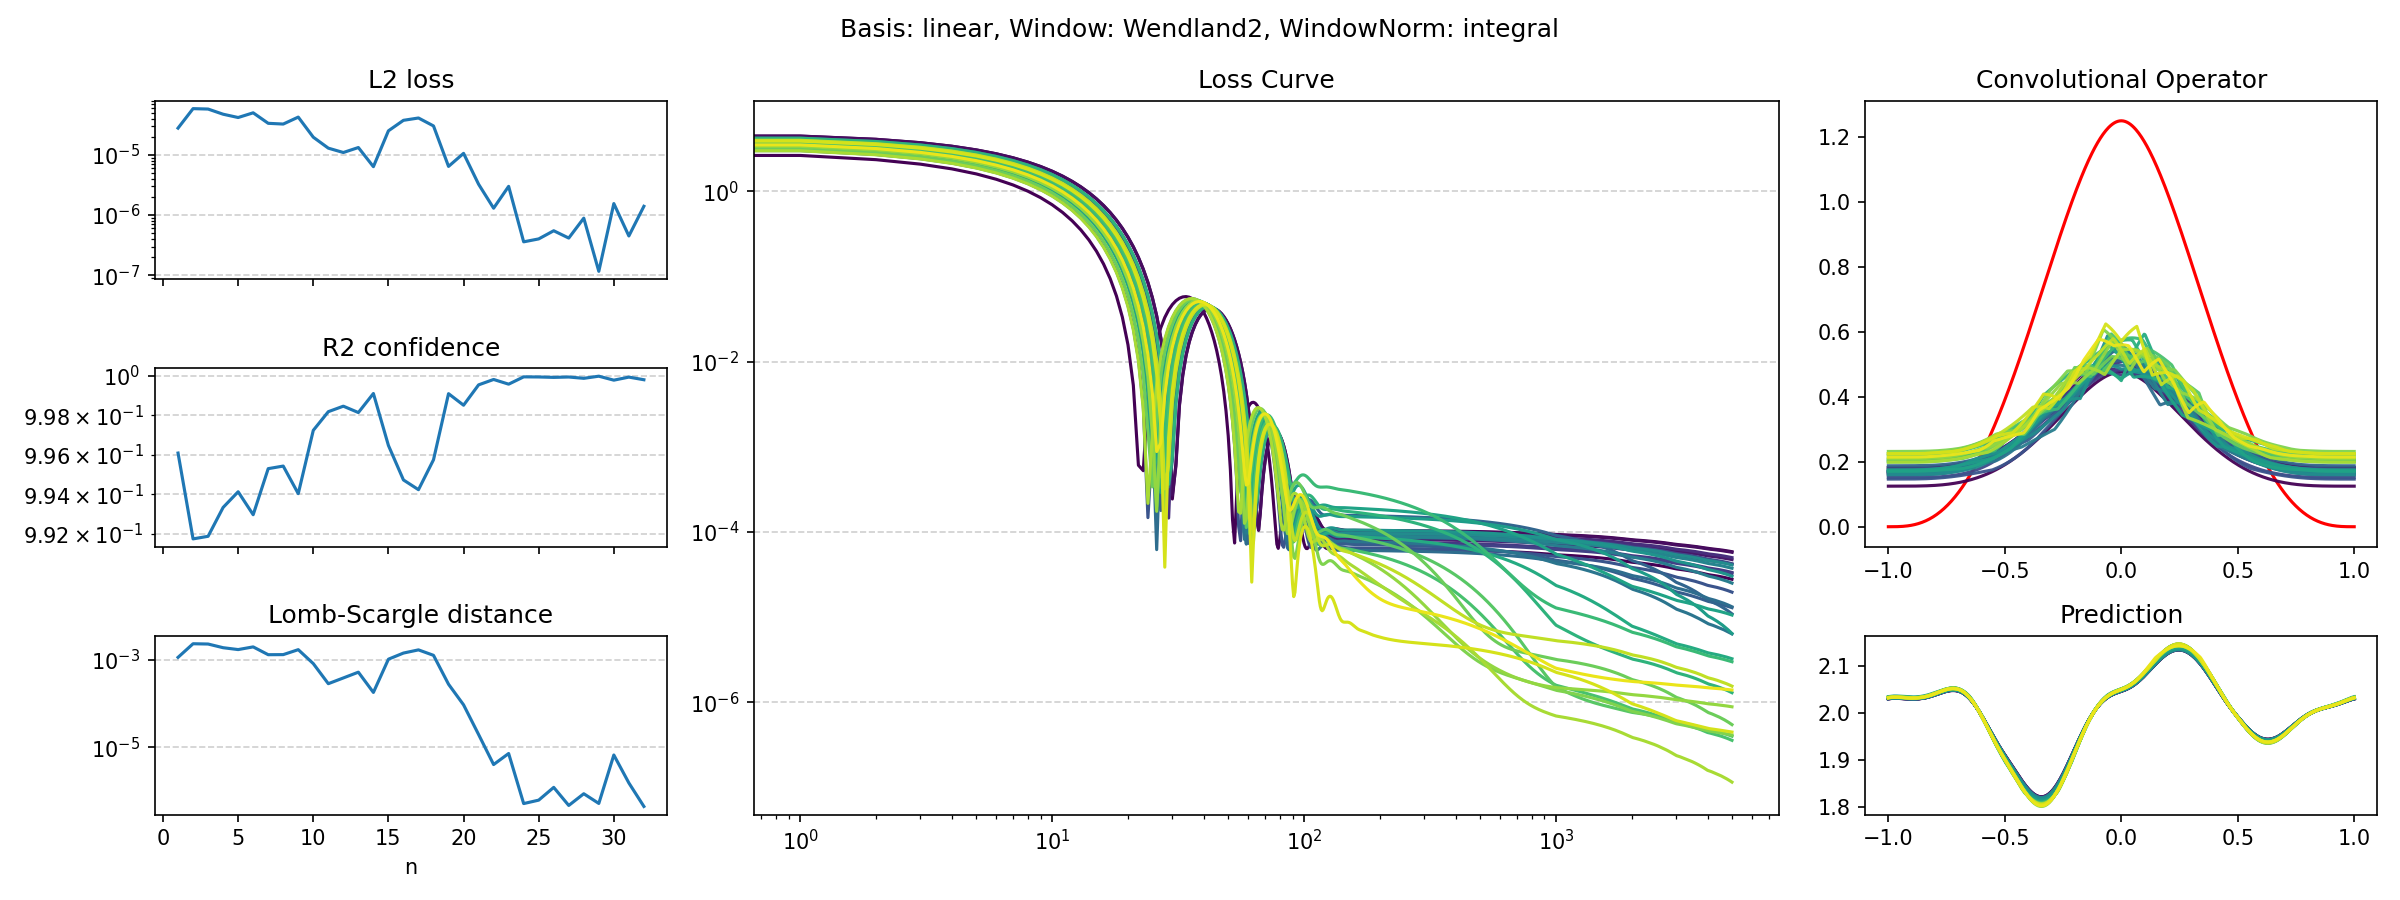

In [29]:
fig, axis = plt.subplot_mosaic('''ABE
CBE
DBF''', figsize=(16,6), sharex = False, width_ratios=[1,2,1])
fig.canvas.draw()
fig.canvas.flush_events()

if not os.path.exists('./images/'):
    os.makedirs('./images/')    
    
basii = ['linear', 'chebyshev', 'fourier', 'rbf cubic_spline', 'abf cubic_spline', 'ubf cubic_spline', 'rbf wendland2', 'rbf square']
windows = [None, 'cubicSpline', 'Wendland2', 'Spiky', 'Linear']

In [ ]:
for basis in tqdm(basii):
    for window in tqdm(windows, leave = False):
        models = []
        for i in tqdm(range(1,32 + 1), leave = False):
            trainedModel = trainModel(particleData, settings, dataSet, trainingFiles,
                                      n = i, basis = basis, layers = [1],
                                 window = window, windowNorm = windowNorm,
                                 epochs = 5, iterations = 1000, initialLR = 1e-2, device = device,
                                 groundTruthFn = getGroundTruth, featureFn = getFeatures, lossFn = lossFunction)
            models.append(trainedModel)
        plotModelsetInteractive(fig, axis, models, device)
        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig('./images/%s_%s_%s.png' % (basis, models[0]['window'] if models[0]['window'] is not None else 'None', models[0]['windowNorm'] if models[0]['windowNorm'] is not None and window is not None else 'None'))
#         print(basis, window)
#         break
#     break

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


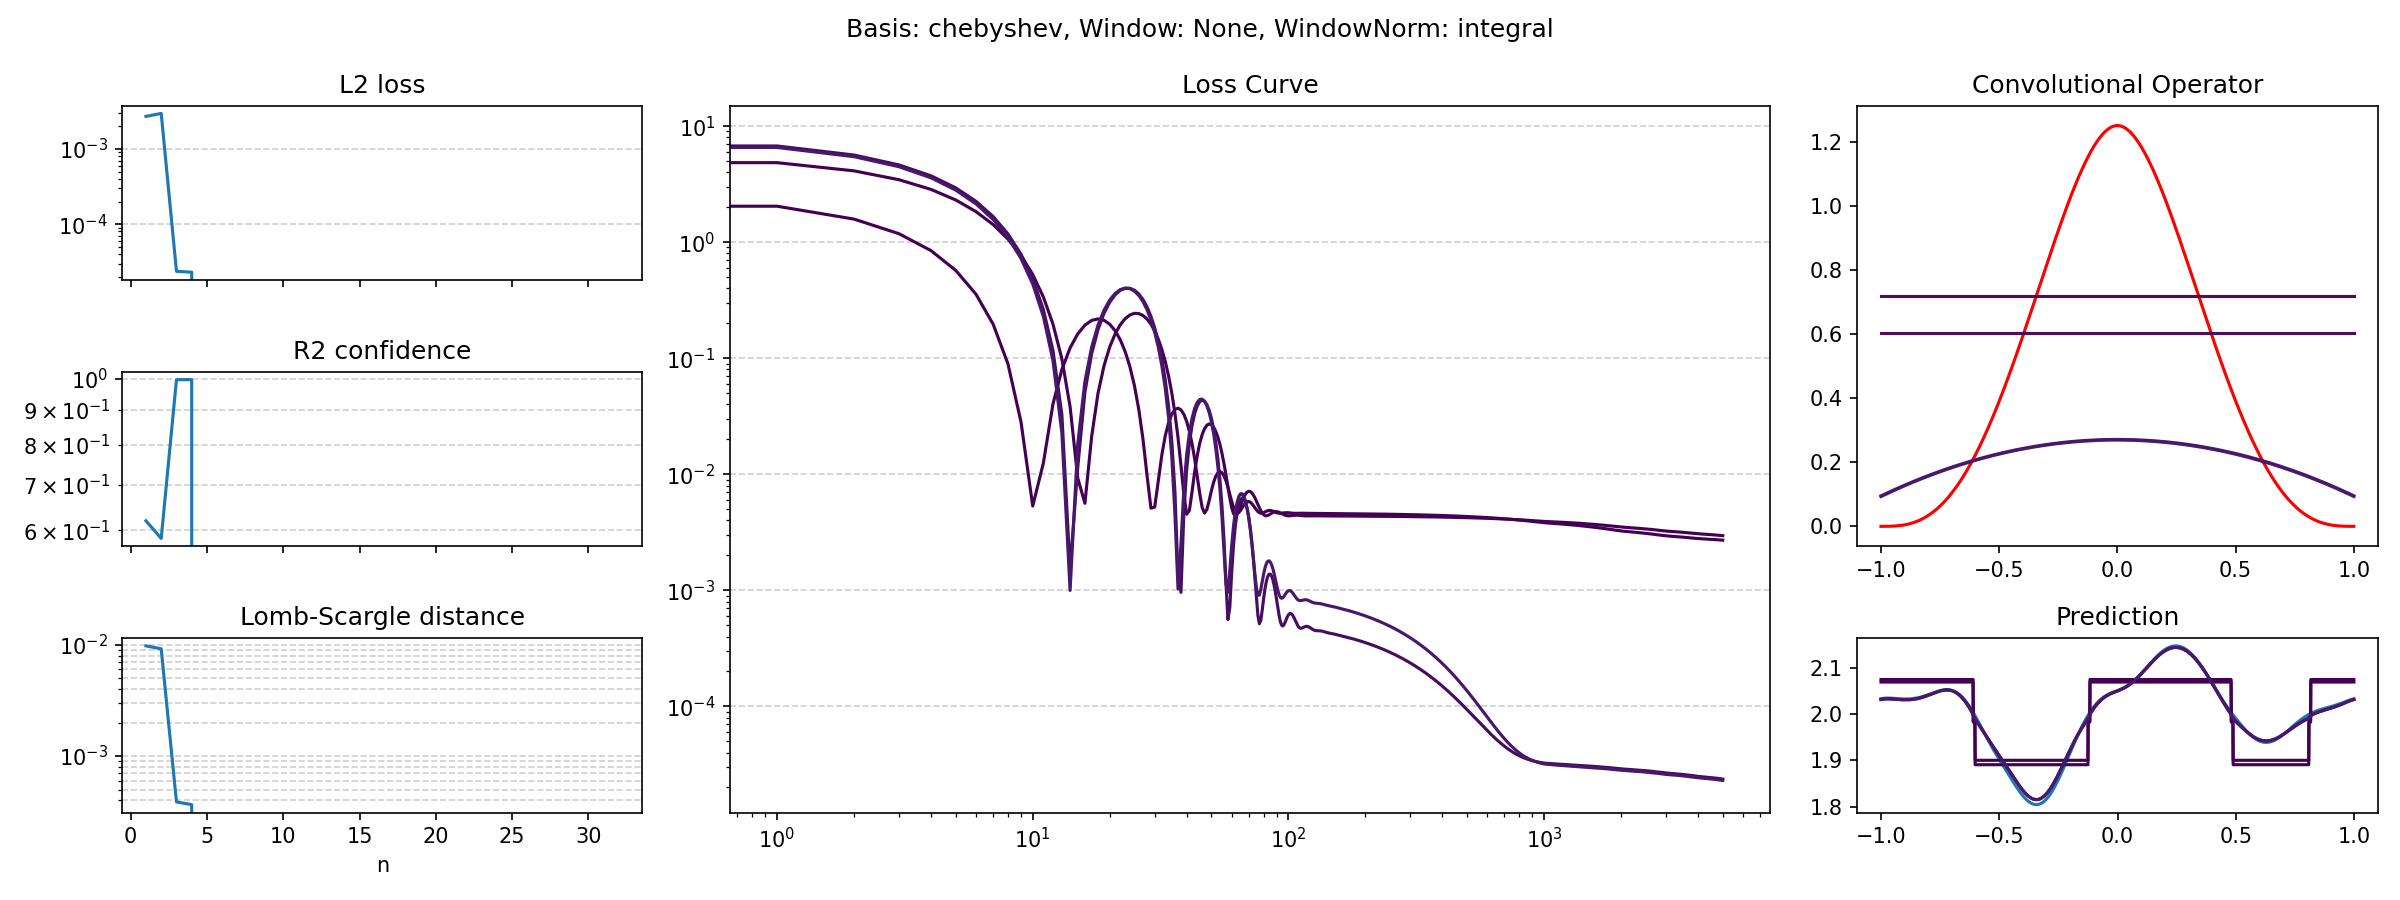

<IPython.core.display.Javascript object>


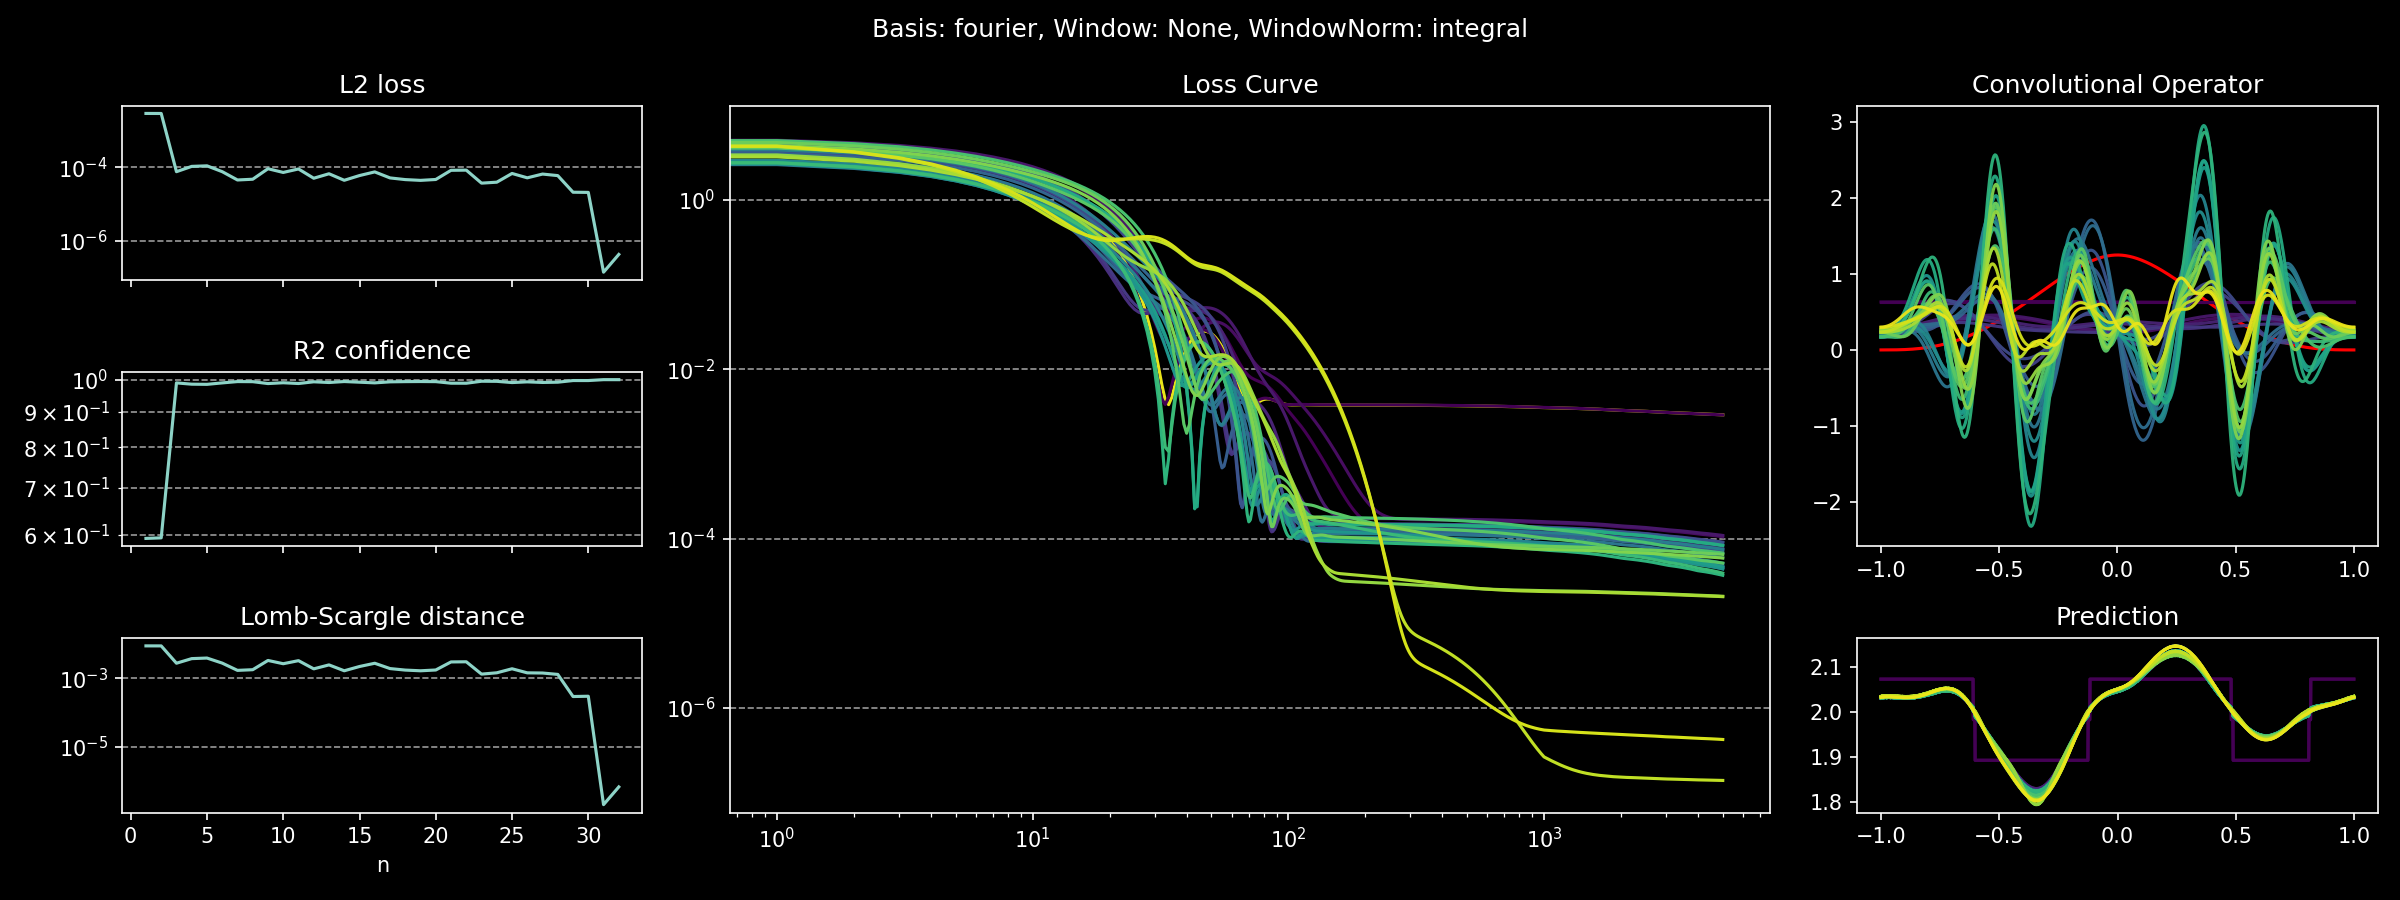

In [129]:
plotModelset(models)

   6.101


<IPython.core.display.Javascript object>


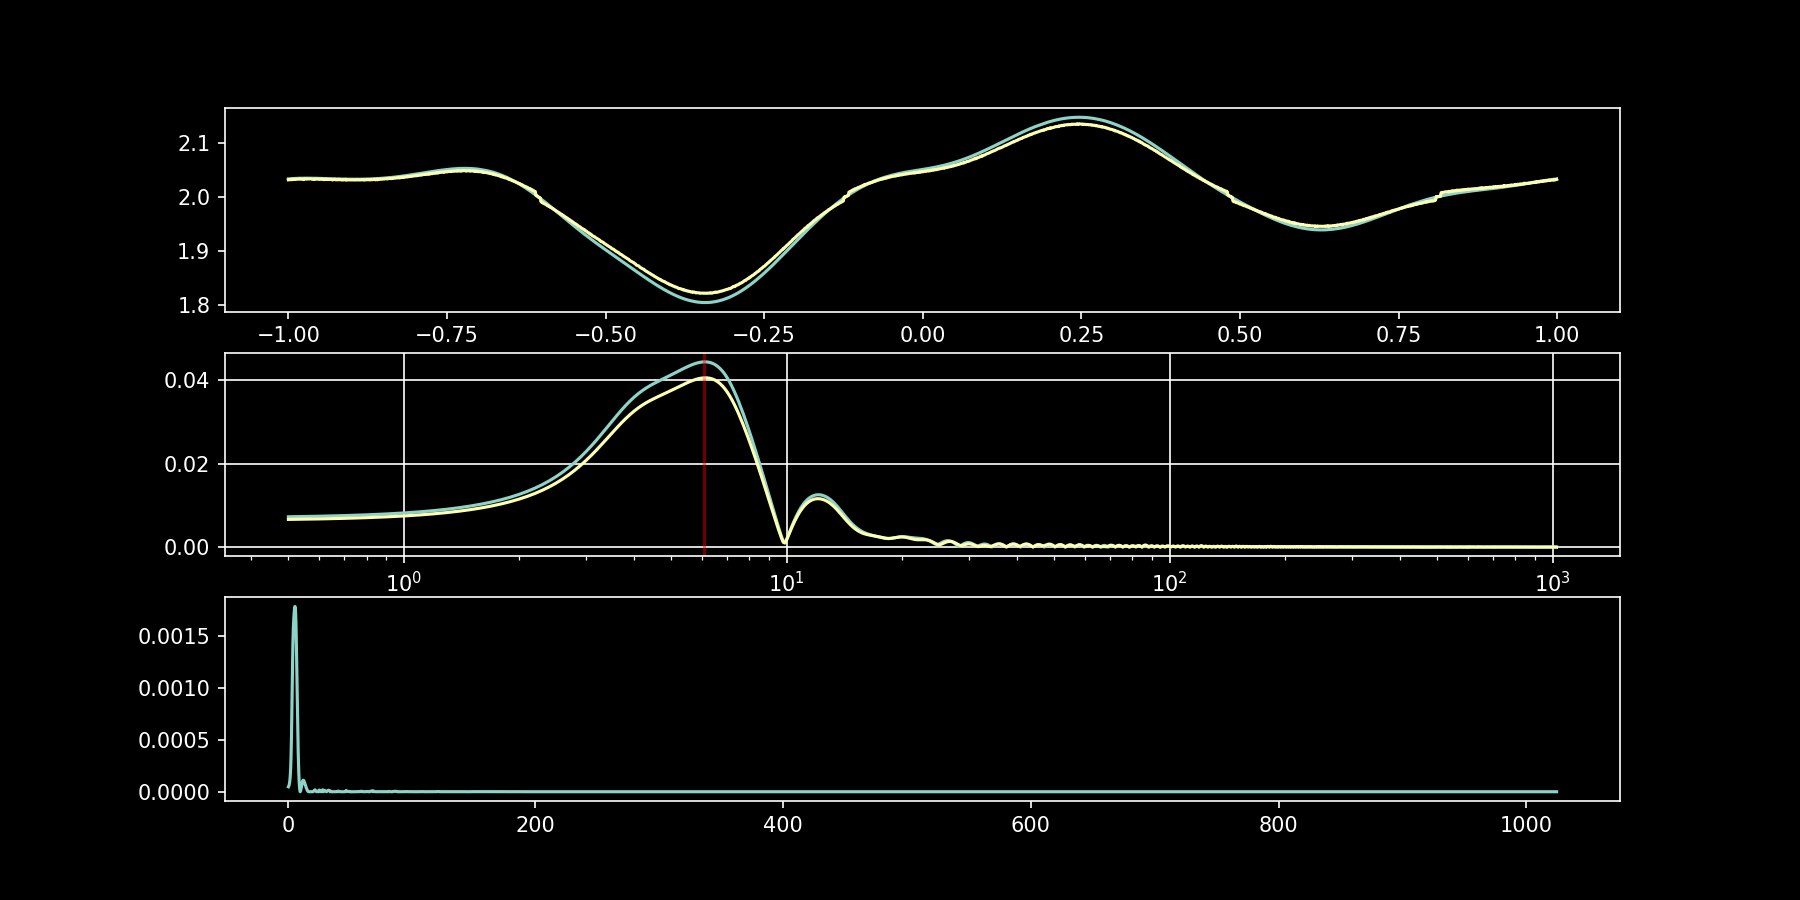

In [46]:
from scipy.signal import lombscargle

x = trainedModel['x'][:,0].numpy()
y = trainedModel['gt'].numpy()
# y = trainedModel['predictions'][-1].numpy()

dxmin = np.diff(x).min()
duration = x.ptp()
x.shape[0]
freqs = np.linspace(1/duration, x.shape[0]/duration, 5*x.shape[0])
periodogram = lombscargle(x, y - np.mean(y), freqs, normalize = False, precenter = True)
periodograma = lombscargle(x, y - np.mean(y), freqs)

kmax = periodogram.argmax()
print("%8.3f" % (freqs[kmax],))

fig, axis = plt.subplots(3, 1, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

axis[0,0].plot(x, y)

axis[1,0].semilogx(freqs, np.sqrt(4*periodogram/(5*x.shape[0])))
axis[1,0].set_xlabel('Frequency (rad/s)')
axis[1,0].grid()
axis[1,0].axvline(freqs[kmax], color='r', alpha=0.25)


y2 = trainedModel['predictions'][-1].numpy()

dxmin = np.diff(x).min()
duration = x.ptp()
freqs = np.linspace(1/duration, x.shape[0]/duration, 5*x.shape[0])
periodogram = lombscargle(x, y2 - np.mean(y), freqs, normalize = False, precenter = True)
periodogramb = lombscargle(x, y2 - np.mean(y), freqs)
axis[0,0].plot(x, y2)
axis[1,0].plot(freqs, np.sqrt(4*periodogram/(5*x.shape[0])))
axis[1,0].axvline(freqs[kmax], color='r', alpha=0.25)

axis[2,0].plot(freqs, (np.sqrt(4*periodograma/(5*n)) - np.sqrt(4*periodogramb/(5*n)))**2)

plt.show()

In [31]:

windowFn = getWindowFunction(window, norm = windowNorm) if window is not None else None


In [32]:
# Setup a single layer neural network using the RbfConv class

    
model = RbfNet(fluidFeatures = 1, 
               layers = [1], 
               denseLayer = True, activation = 'ReLU', coordinateMapping = 'cartesian', 
               n = n, windowFn = windowFn, rbf = basis, batchSize = computeBatchSize, ignoreCenter = True, normalized = False).to(device)

# model = RbfNet(fluidFeatures = 1, 
#                layers = [1], 
#                denseLayer = True, activation = 'ReLU', coordinateMapping = 'cartesian', 
#                n = n, windowFn = None, rbf = basis, batchSize = computeBatchSize, ignoreCenter = True, normalized = False).to(device)

print('Network has', count_parameters(model), 'parameters')
# Create optimizer for the network
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)



Network has 18 parameters


In [33]:

# i, j, distance, direction = batchedNeighborsearch(positions, setup)
# x, u, v, dudt = flatten(positions, velocities, density, dudts)
# x = x[:,None]

In [34]:
lr = 1e-2
optimizer.zero_grad()
positions, velocities, areas, dudts, density, setup = loadFrames(particleData, settings, dataSet, trainingFiles[0], 0 + np.arange(1), device)
#                 positions, velocities, areas, dudts, setup = loadBatch(particleData, settings, dataSet, bdata, device)

i, j, distance, direction = batchedNeighborsearch(positions, setup)
x, u, v, rho, dudt = flatten(positions, velocities, areas, density, dudts)

x = x[:,None].to(device)
groundTruth = getGroundTruth(positions, velocities, areas, density, dudts).to(device)
distance = (distance * direction)[:,None].to(device)
features = getFeatures(x, u, v, rho, dudt).to(device)

predictions = []
losses = []
for e in (pb := tqdm(range(epochs))):
    for b in (pbl := tqdm(range(iterations), leave=False)):
        optimizer.zero_grad()
        prediction = model(features.to(device), i.to(device), j.to(device), distance.to(device))[:,0]
        lossTerm = lossFunction(prediction, groundTruth)
        loss = torch.mean(lossTerm)

    #     print(prediction)
    #     print(groundTruth)
    #     print(lossTerm)

        loss.backward()
        optimizer.step()
        predictions.append(prediction.detach().cpu())
        losses.append(lossTerm.detach().cpu())
        pbl.set_description('%8s[gpu %d]: %3d [%1d] @ %1.1e: :  %s -> %.2e' %('overfitting', 0, 0, 0, lr, '0', loss.detach().cpu().numpy()))
    
#     break
    if True: #epoch % 1 == 0 and epoch > 0:
        lr = lr * 0.95
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']
# store the losses for later processing
# losses.append(lossTerm.detach().cpu().numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [35]:
print(features)

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])


In [36]:
print(prediction)

tensor([2.0315, 2.0318, 2.0319,  ..., 2.0315, 2.0315, 2.0320],
       grad_fn=<SelectBackward0>)


In [37]:
print(groundTruth)

tensor([2.0329, 2.0330, 2.0331,  ..., 2.0326, 2.0327, 2.0328])


<IPython.core.display.Javascript object>


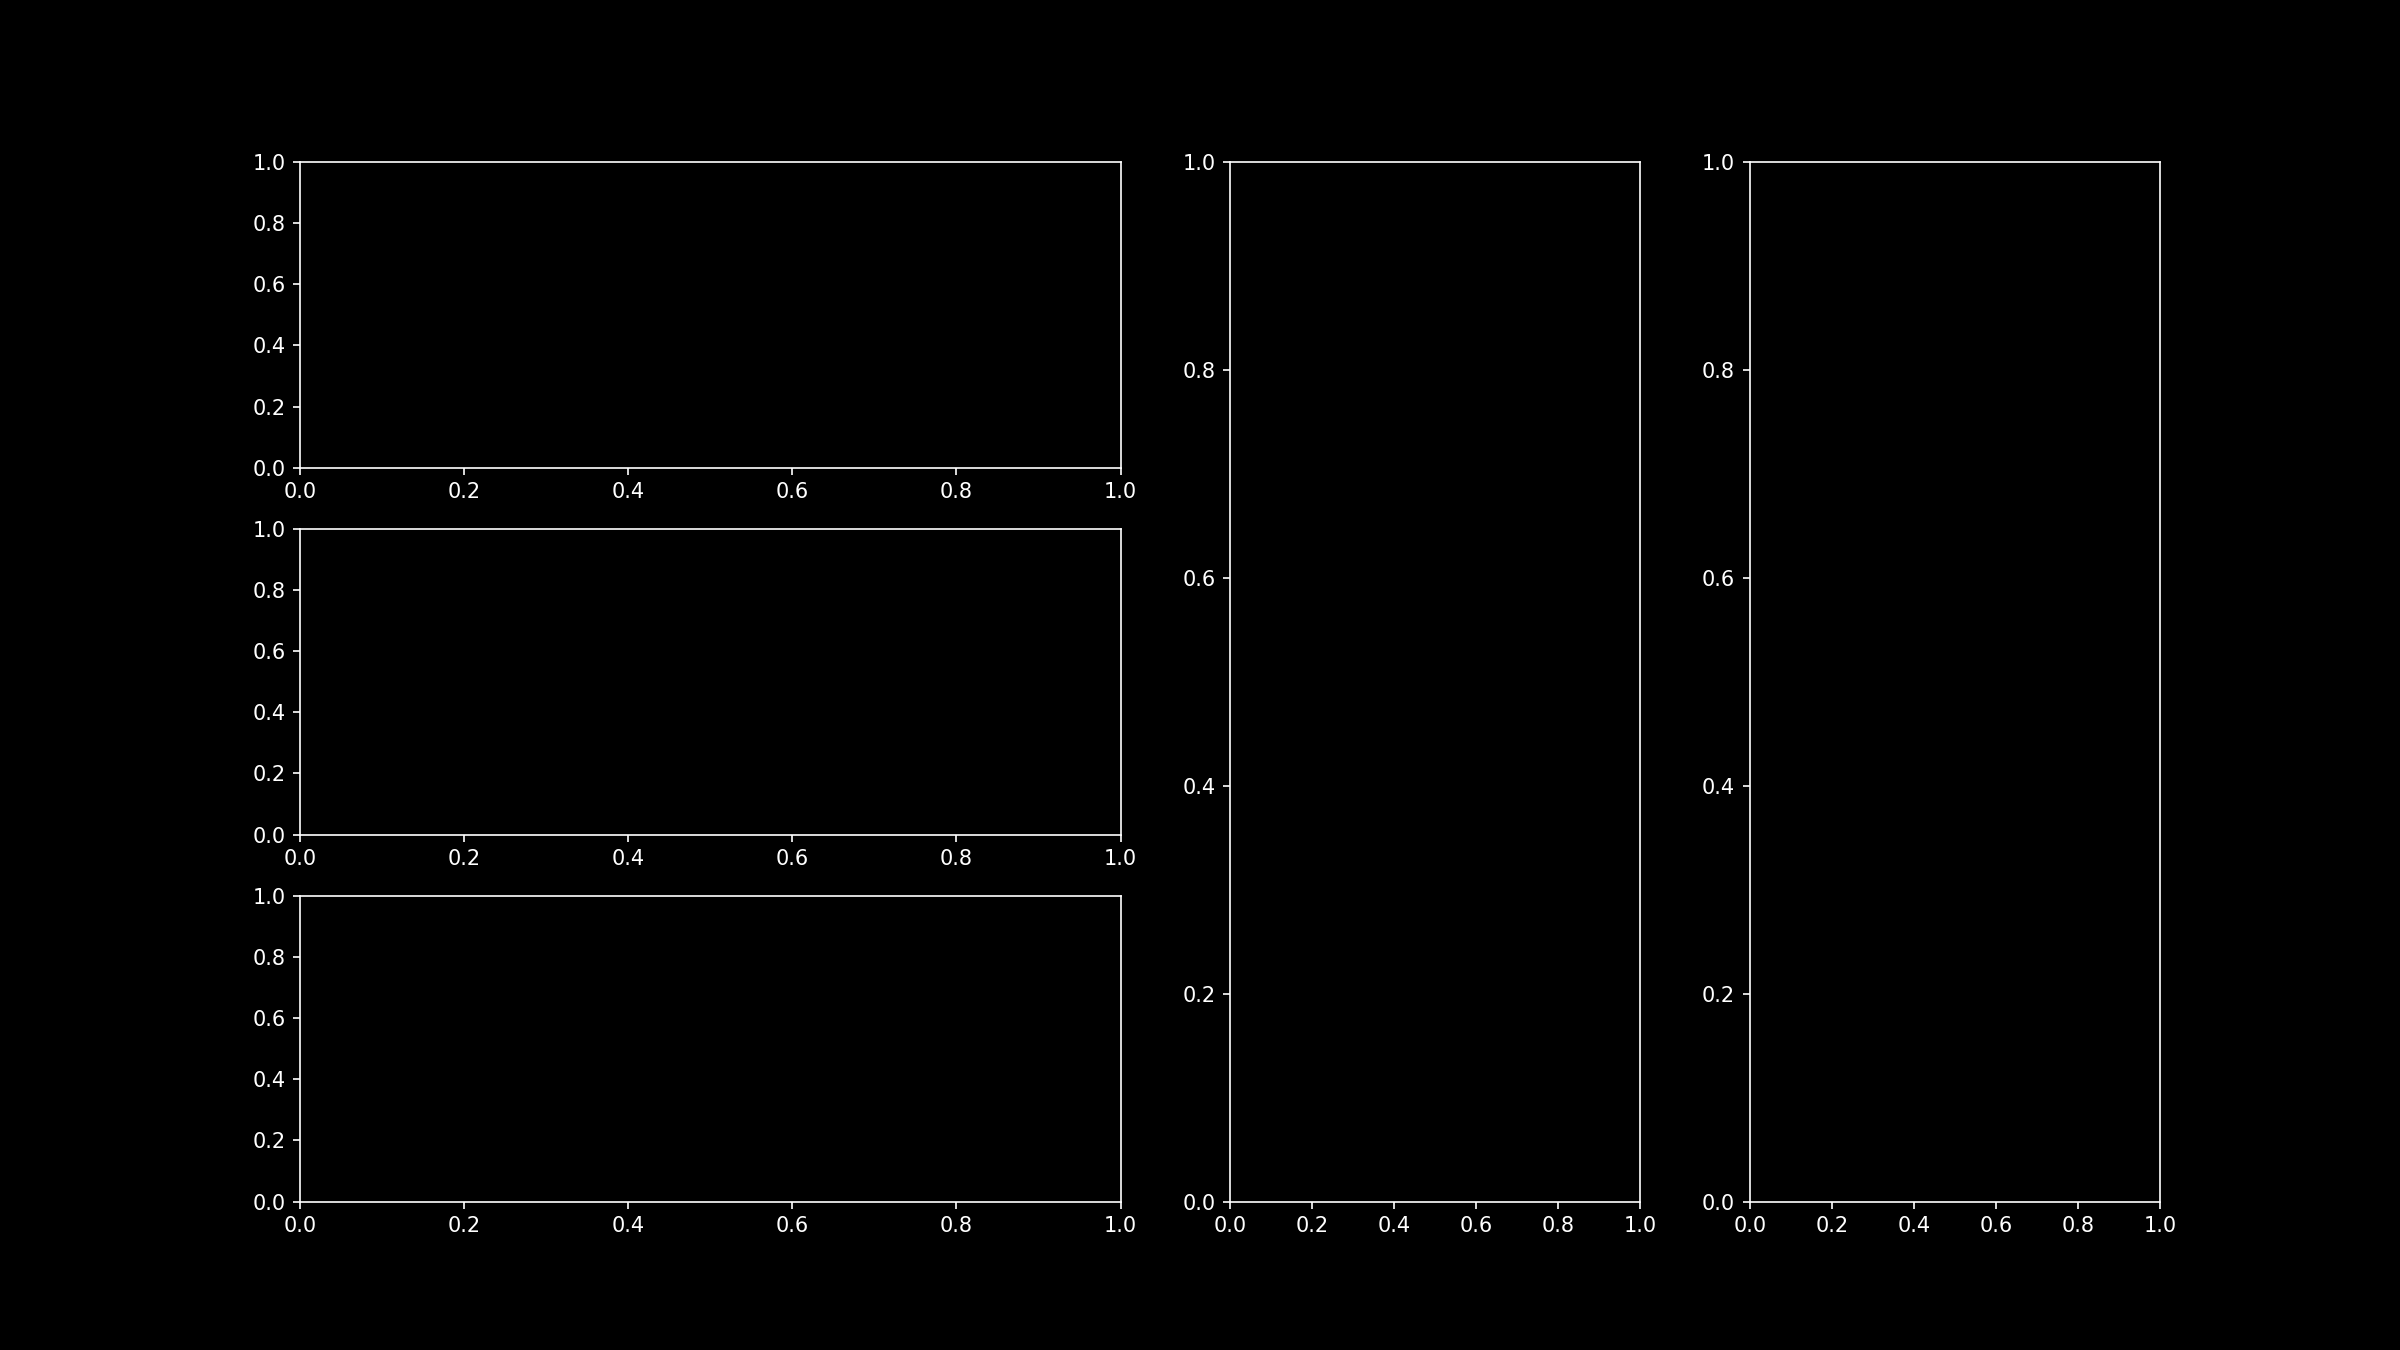

KeyError: 'groundTruths'

<IPython.core.display.Javascript object>


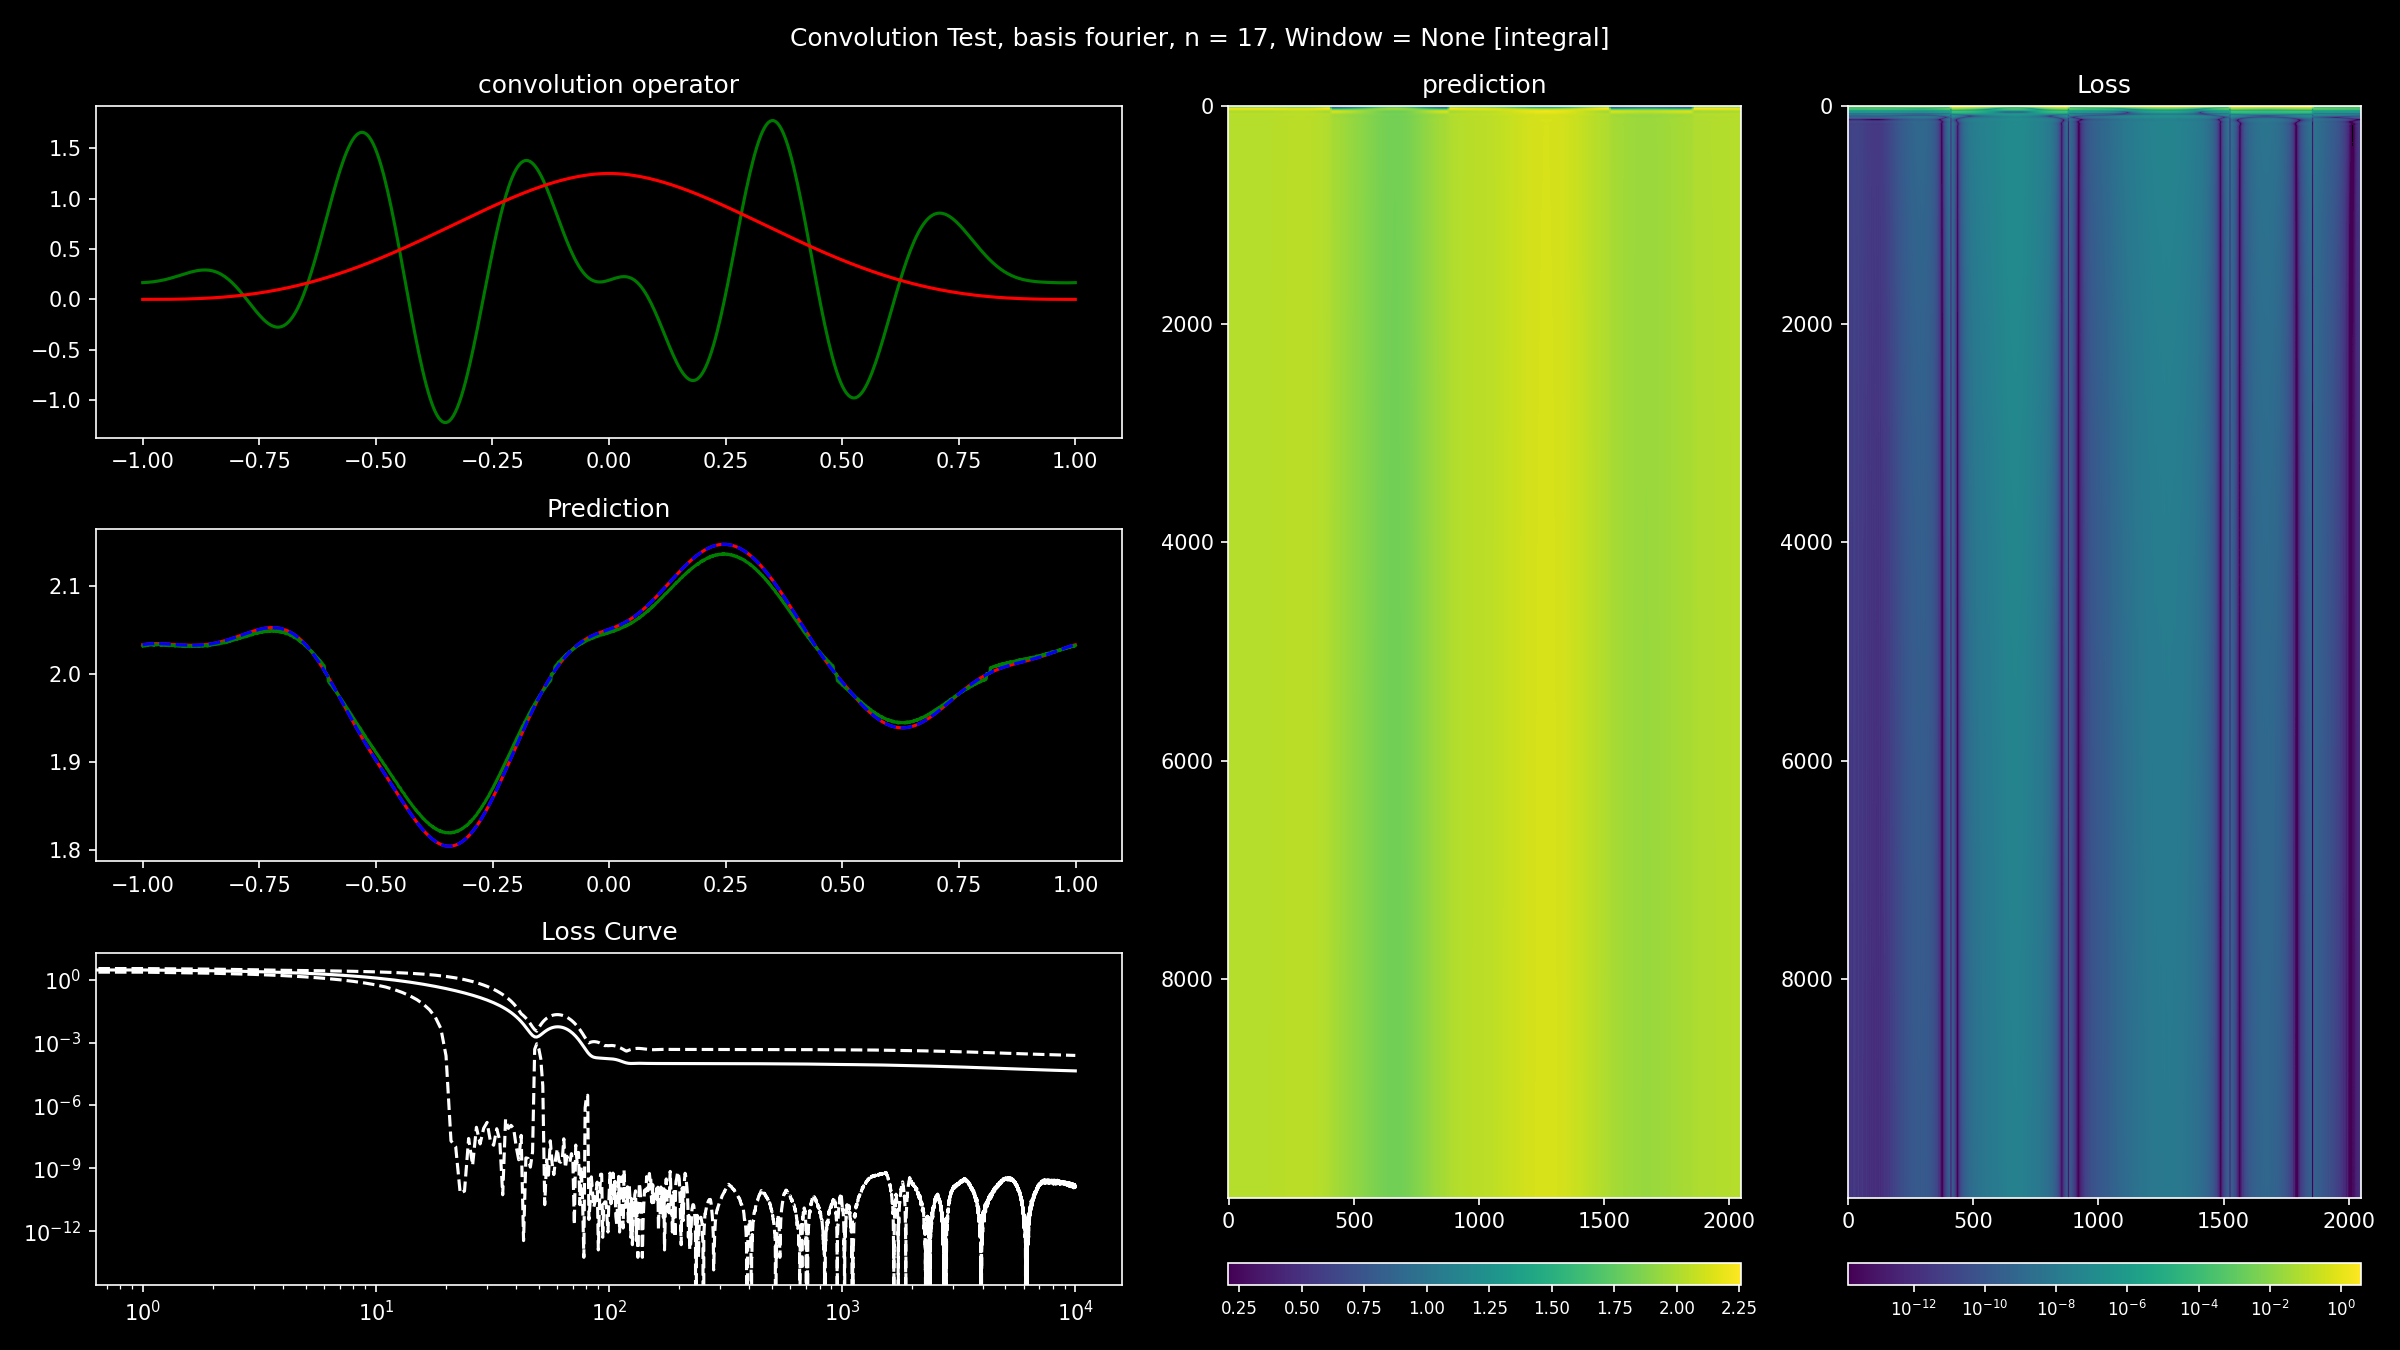

In [41]:
fig, axis = plt.subplot_mosaic('''DBC
ABC
EBC''', figsize=(16,9), sharex = False, width_ratios=[2,1,1])

def plot(fig, axis, mat, title, cmap = 'viridis', norm = 'linear'):
    im = axis.imshow(mat, cmap = cmap, norm = norm)
    axis.axis('auto')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("bottom", size="2%", pad="6%")
    cb1 = fig.colorbar(im, cax=cax1,orientation='horizontal')
    cb1.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    
axis['A'].plot(x[:,0], groundTruth.detach().cpu().numpy(), c = 'red')
ll = np.logspace(1, np.log10(iterations * epochs + 1), num = 100)
norm = LogNorm(vmin=1, vmax=iterations * epochs + 1)
    
axis['A'].plot(x[:,0], predictions[-1][:], c = 'green')
s = scatter_sum(baseArea * kernel(torch.abs(distance[:,0]), particleSupport), i, dim = 0, dim_size = x.shape[0])
axis['A'].plot(x[:,0], s, c = 'blue', ls = '--')
    
    
plot(fig, axis['B'], torch.vstack(predictions)[:,:], title = 'prediction', norm = 'linear')
plot(fig, axis['C'], torch.vstack(losses)[:,:], title = 'Loss', norm = 'log')

xSynthetic, featuresSynthetic, iSynthetic, jSynthetic = generateSyntheticData(511, device)

steps = iterations * epochs
ls = np.logspace(0, np.log10(steps), num =  50)
ls = [int(np.floor(f)) for f in ls]
ls = np.unique(ls).tolist()

axis['D'].plot(xSynthetic[:,0].detach().cpu().numpy(), model(featuresSynthetic, iSynthetic, jSynthetic, xSynthetic).detach().cpu().numpy(),ls='-',c= 'green', alpha = 0.95)
axis['D'].plot(xSynthetic[:,0].detach().cpu().numpy(), kernel(torch.abs(xSynthetic), 1).detach().cpu().numpy(), c = 'red')

axis['D'].set_title('convolution operator')
axis['A'].set_title('Prediction')

axis['E'].loglog(torch.mean(torch.vstack(losses), dim = 1), ls = '-', c = 'white')
axis['E'].loglog(torch.min(torch.vstack(losses), dim = 1)[0], ls = '--', c = 'white')
axis['E'].loglog(torch.max(torch.vstack(losses), dim = 1)[0], ls = '--', c = 'white')
axis['E'].set_title('Loss Curve')
fig.suptitle('Convolution Test, basis %s, n = %2d, Window = %s [%s]' % (basis, n, window if window is not None else 'None', windowNorm if windowNorm is not None else 'None'))

fig.tight_layout()

In [85]:
torch.min(torch.linalg.norm(distance, axis = 1))

tensor(0.)

In [118]:
from tqdm.notebook import tqdm

In [119]:
pb = tqdm(range(epochs * iterations))
epoch = 0
b, l, w = processDataLoaderIter(pb, iterations, epoch, lr, \
                                dataLoader, dataIter, batchSize, model, optimizer, \
                                particleData, settings, dataSet, \
                                lossFunction, getFeatures, getGroundTruth, None,\
                                train = True, prefix = '', augmentAngle = False, augmentJitter = False, jitterAmount = 0.01)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [113]:
testFile = trainingFiles[2]
testFrame = 0
unrollLength = 32



positions, velocities, areas, dudts, densities, setup = loadFrames(particleData, settings, dataSet, testFile, testFrame + np.arange(unrollLength), device)

i, j, distance, direction = batchedNeighborsearch(positions, setup)
x, u, v, dudt = flatten(positions, velocities, areas, dudts)
x = x[:,None]
distance = distance[:,None]
features = torch.vstack((u, torch.ones_like(v))).mT

In [115]:
predictions = []
with torch.no_grad():
    for i in range(unrollLength):
        predictions.append(modelStep([positions[i]], [velocities[i]], [densities[i]], setup).cpu())
predictions = torch.vstack(predictions)

<IPython.core.display.Javascript object>


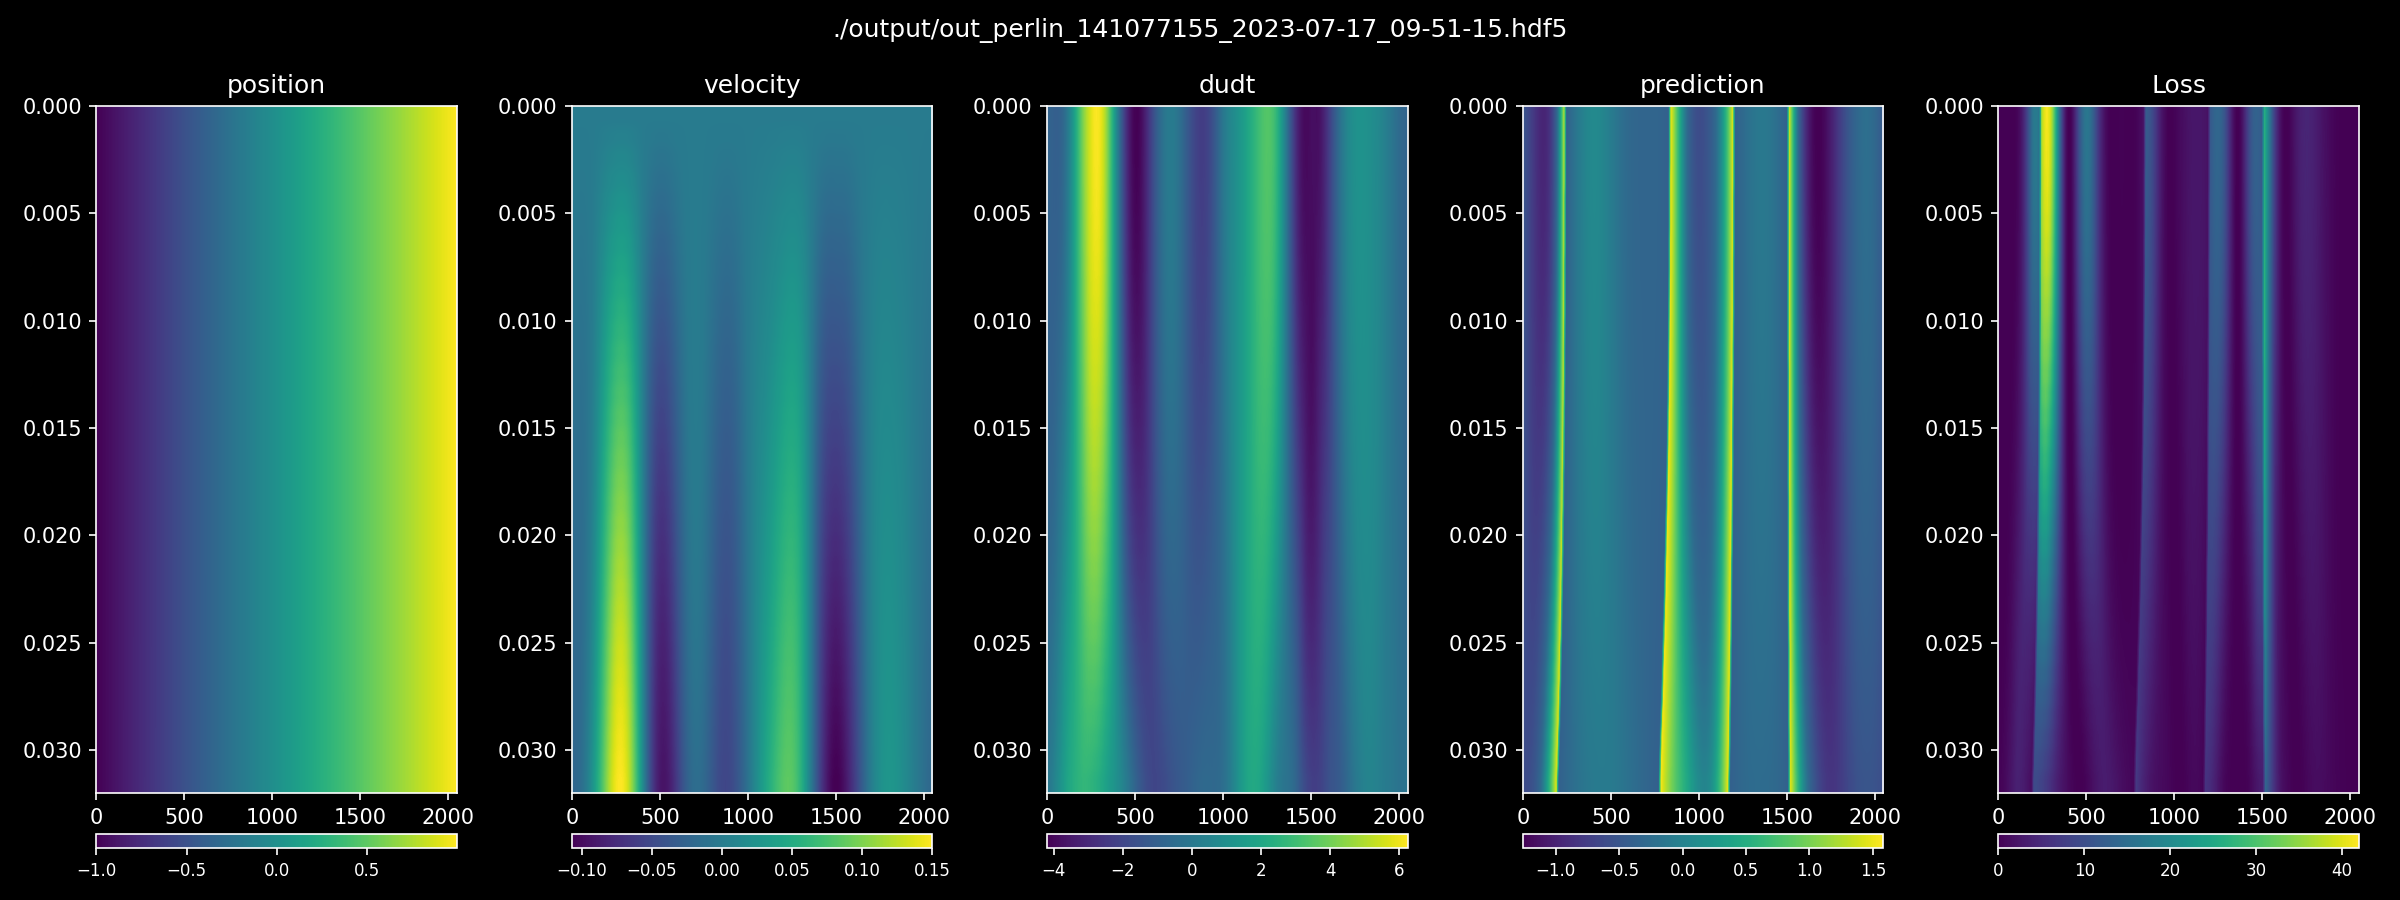

In [116]:

fig, axis = plt.subplots(1, 5, figsize=(16,6), sharex = False, sharey = False, squeeze = False)

def plot(fig, axis, mat, title, cmap = 'viridis'):
    im = axis.imshow(mat, extent = [0,numParticles,dt * (unrollLength + testFrame), testFrame * dt], cmap = cmap)
    axis.axis('auto')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("bottom", size="2%", pad="6%")
    cb1 = fig.colorbar(im, cax=cax1,orientation='horizontal')
    cb1.ax.tick_params(labelsize=8) 
    axis.set_title(title)
plot(fig,axis[0,0], x.reshape((unrollLength, numParticles)), 'position')
plot(fig,axis[0,1], u.reshape((unrollLength, numParticles)), 'velocity')
plot(fig,axis[0,2], dudt.reshape((unrollLength, numParticles)) / dt, 'dudt')
plot(fig,axis[0,3], predictions, 'prediction')
plot(fig,axis[0,4], (dudt.reshape((unrollLength, numParticles)) / dt - predictions)**2, 'Loss')
# plot(fig,axis[0,1], fluidDensity, 'density')
# plot(fig,axis[0,2], fluidPressure, 'pressure')
# plot(fig,axis[0,3], fluidVelocities, 'velocity', 'RdBu')
# plot(fig,axis[0,4], dudt, 'dudt', 'RdBu')

fig.suptitle(trainingFiles[0])
fig.tight_layout()

In [51]:

positions, velocities, areas, dudts, setup = loadBatch(particleData, settings, dataSet, bdata, device)

i, j, distance, direction = batchedNeighborsearch(positions, setup)
x, u, v, dudt = flatten(positions, velocities, areas, dudts)
x = x[:,None]
distance = distance[:,None]
features = torch.vstack((u, torch.ones_like(v))).mT

In [52]:
model(features, i, j, distance).reshape(4,2048)

tensor([[-0.0576, -0.0575, -0.0574,  ..., -0.0579, -0.0577, -0.0577],
        [-0.0355, -0.0355, -0.0354,  ..., -0.0357, -0.0357, -0.0356],
        [-0.0245, -0.0244, -0.0242,  ..., -0.0249, -0.0248, -0.0246],
        [-0.0670, -0.0671, -0.0672,  ..., -0.0667, -0.0668, -0.0669]],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [48]:
print(x.shape, x.reshape(4,2048))
print(positions)

torch.Size([8192, 1]) tensor([[-1.0040, -1.0030, -1.0020,  ...,  0.9931,  0.9940,  0.9950],
        [-1.0024, -1.0014, -1.0004,  ...,  0.9945,  0.9955,  0.9966],
        [-0.9568, -0.9558, -0.9547,  ...,  1.0401,  1.0411,  1.0422],
        [-1.0343, -1.0333, -1.0323,  ...,  0.9627,  0.9637,  0.9647]],
       device='cuda:0')
[tensor([-1.0040, -1.0030, -1.0020,  ...,  0.9931,  0.9940,  0.9950],
       device='cuda:0'), tensor([-1.0024, -1.0014, -1.0004,  ...,  0.9945,  0.9955,  0.9966],
       device='cuda:0'), tensor([-0.9568, -0.9558, -0.9547,  ...,  1.0401,  1.0411,  1.0422],
       device='cuda:0'), tensor([-1.0343, -1.0333, -1.0323,  ...,  0.9627,  0.9637,  0.9647],
       device='cuda:0')]
